In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:50% !important; }</style>"))

%matplotlib inline

import os
import re
import json
from collections import defaultdict

import torch
import gpytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap.umap_ as umap
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from rdkit import Chem
from botorch.models.gpytorch import GPyTorchModel
from botorch.fit import fit_gpytorch_model
from MDAnalysis.analysis.rms import rmsd
from scipy.stats import pearsonr
from map4 import MAP4Calculator

## Read dataset

In [2]:
mhci = pd.read_csv('../mhc/binding_data_2013/bdata.20130222.mhci.csv')

In [3]:
# We removed those binding affinity values
# A lot of peptides were set with those values. Looks like some default values assigned...
dirty_values = [1, 2, 3, 5000, 10000, 20000, 43424, 50000, 69444.44444, 78125]

# Split dataset in training and testing sets
mhci = mhci[(mhci['mhc_allele'] == 'HLA-A*02:01') &
            (mhci['length'] == 9) &
            (~mhci['affinity_binding'].isin(dirty_values))]

## Correlation between PSSM and exp. values

In [5]:
data = []
AA = []

with open('../mhc/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smm_matrix/HLA-A-02:01-9.txt') as f:
    lines = f.readlines()
    
    for line in lines[1:-1]:
        sline = line.strip().split('\t')
        AA.append(sline[0])
        data.append([float(v) for v in sline[1:]])

columns = list(range(1, 10))
pssm = pd.DataFrame(data=data, columns=columns, index=AA)

In [6]:
pssm_scores = []

for peptide in mhci.itertuples():
    score = 0
    
    for i, aa in enumerate(peptide.sequence):
        score += pssm.loc[aa][i + 1]
    
    pssm_scores.append(score)
    
pssm_scores = np.array(pssm_scores)

In [7]:
# Fit PSSM score to exp. values
reg = LinearRegression()
reg.fit(pssm_scores[:,None], mhci['energy'])
print('R2: %.3f' % reg.score(pssm_scores[:,None], mhci['energy']))
print('RMSD : %.3f kcal/mol' % rmsd(reg.predict(pssm_scores[:,None]), mhci['energy']))

R2: 0.644
RMSD : 1.189 kcal/mol


## Bayesian optimization

In [8]:
class TanimotoSimilarityKernel(gpytorch.kernels.Kernel):
    # the sequence kernel is stationary
    is_stationary = True     

    # this is the kernel function
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        if last_dim_is_batch:
            # Not tested
            x1 = x1.transpose(-1, -2).unsqueeze(-1)
            x2 = x2.transpose(-1, -2).unsqueeze(-1)

        x1_eq_x2 = torch.equal(x1, x2)
        
        x1s = torch.sum(torch.square(x1), dim=-1)
        x2s = torch.sum(torch.square(x2), dim=-1)
        
        if diag:
            if x1_eq_x2:
                res = torch.ones(*x1.shape[:-2], x1.shape[-2], dtype=x1.dtype, device=x1.device)
                return res
            else:
                product = torch.mul(x1, x2).sum(dim=1)
                denominator = torch.add(x2s, x1s) - product
        else:
            product = torch.mm(x1, x2.transpose(1, 0))
            denominator = torch.add(x2s, x1s[:, None]) - product

        res = product / denominator
        
        return res

    
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP, GPyTorchModel):
    # to inform GPyTorchModel API
    _num_outputs = 1
    
    def __init__(self, train_x, train_y, likelihood, kernel=None):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        if kernel is not None:
            self.covar_module = gpytorch.kernels.ScaleKernel(kernel())
        else:
            self.covar_module = gpytorch.kernels.ScaleKernel(TanimotoSimilarityKernel())

        # make sure we're on the right device/dtype
        self.to(train_x)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    
def get_fitted_model(train_x, train_y, state_dict=None, kernel=None):
    # initialize and fit model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood, kernel)
    
    if state_dict is not None:
        model.load_state_dict(state_dict)
    
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    mll.to(train_x)
    
    # Train model!
    fit_gpytorch_model(mll)
    
    return model

In [9]:
def predict(model, likelihood, test_x):
    model.eval()
    likelihood.eval()
    
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))


def plot(y_test, observed_pred, fig_filename=None):
    with torch.no_grad():
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        
        ax.scatter(y_test, observed_pred)
        
        ax.set_xlim([np.min([y_test, observed_pred]) - 1, np.max([y_test, observed_pred]) + 1])
        ax.set_ylim([np.min([y_test, observed_pred]) - 1, np.max([y_test, observed_pred]) + 1])
        ax.set_xlabel('Experimental values (kcal/mol)', fontsize=20)
        ax.set_ylabel('Predicted values (kcal/mol)', fontsize=20)
        
        if fig_filename is not None:
            plt.savefig(fig_filename, bbox_inches='tight', dpi=300)
        
        plt.show()

In [10]:
def expected_improvement(model, Y_train, Xsamples, greater_is_better=False, xi=0.00):
    """ expected_improvement
    Expected improvement acquisition function.
    
    Source: https://github.com/thuijskens/bayesian-optimization/blob/master/python/gp.py
    
    Arguments:
    ----------
        model: Gaussian process model
        Y_train: Array that contains all the observed energy interaction seed so far
        X_samples: Samples we want to try out
        greater_is_better: Indicates whether the loss function is to be maximised or minimised.
        xi: Exploitation-exploration trade-off parameter

    """
    # calculate mean and stdev via surrogate function
    observed_pred = predict(model, model.likelihood, Xsamples)
    sigma = observed_pred.variance.sqrt().detach().numpy()
    mu = observed_pred.mean.detach().numpy()

    if greater_is_better:
        loss_optimum = np.max(Y_train.numpy())
    else:
        loss_optimum = np.min(Y_train.numpy())

    scaling_factor = (-1) ** (not greater_is_better)

    # calculate the expected improvement
    Z = scaling_factor * (mu - loss_optimum - xi) / (sigma + 1E-9)
    ei = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + (sigma * norm.pdf(Z))
    ei[sigma == 0.0] == 0.0

    return -1 * ei


# probability of improvement acquisition function
def probability_of_improvement(model, Y_train, Xsamples, greater_is_better=False):
    """ probability_of_improvement
    Probability of improvement acquisition function.
        
    Arguments:
    ----------
        model: Gaussian process model
        Y_train: Array that contains all the observed energy interaction seed so far
        X_samples: Samples we want to try out
        greater_is_better: Indicates whether the loss function is to be maximised or minimised.

    """
    # calculate mean and stdev via surrogate function
    observed_pred = predict(model, model.likelihood, Xsamples)
    sigma = observed_pred.variance.sqrt().detach().numpy()
    mu = observed_pred.mean.detach().numpy()
    
    if greater_is_better:
        loss_optimum = np.max(Y_train.numpy())
    else:
        loss_optimum = np.min(Y_train.numpy())

    scaling_factor = (-1) ** (not greater_is_better)
    
    # calculate the probability of improvement
    Z = scaling_factor * (mu - loss_optimum) / (sigma + 1E-9)
    pi = norm.cdf(Z)
    pi[sigma == 0.0] == 0.0
    
    return pi

In [11]:
def predict_peptide_affinity_binding(sequences, pssm, reg, cutoff=-5.0):
    scores = []
    
    for sequence in sequences:
        score = 0
        
        for i, aa in enumerate(sequence):
            score += pssm.loc[aa][i + 1]
        
        scores.append(score)
    
    pred_scores = reg.predict(np.array(scores)[:,None])
    pred_scores[pred_scores > cutoff] = 0.
    
    return pred_scores


def generate_random_peptides(n_peptides, peptide_length, pssm, reg, energy_bounds, energy_cutoff):
    random_peptides = []
    random_peptide_scores = []

    while True:
        p = ''.join(np.random.choice(pssm.index, peptide_length))
        s = predict_peptide_affinity_binding([p], pssm, reg, cutoff=energy_cutoff)[0]

        if energy_bounds[0] <= s <= energy_bounds[1]:
            random_peptides.append(p)
            random_peptide_scores.append(s)

        if len(random_peptides) == n_peptides:
            break

    random_peptides = np.array(random_peptides)
    random_peptide_scores = np.array(random_peptide_scores)
    
    return random_peptides, random_peptide_scores

In [32]:
def map4_fingerprint(molecule_strings, input_type='fasta', dimensions=4096, radius=2, is_counted=False, is_folded=True):
    f = {'fasta': Chem.rdmolfiles.MolFromFASTA,
         'smiles': Chem.rdmolfiles.MolFromSmiles,
         'helm': Chem.rdmolfiles.MolFromHELM}
    
    MAP4_unf = MAP4Calculator(dimensions=dimensions, radius=radius, is_counted=is_counted, is_folded=is_folded)
    fps = MAP4_unf.calculate_many([f[input_type](s) for s in molecule_strings])
    return torch.from_numpy(np.array(fps)).float()

In [21]:
class AcqScoring:
    def __init__(self, model, acq_fun, y_exp, sequence_type='fasta'):
        self._model = model
        self._acq_fun = acq_fun
        self._y_exp = y_exp
        self._sequence_type = sequence_type
        
    def evaluate(self, sequences):
        fps = map4_fingerprint(sequences, self._sequence_type)
        return self._acq_fun(self._model, self._y_exp, fps)

### Candidate peptides sampling with PBIL

In [62]:
class PBIL(object):
    def __init__(self, scorer, peptide_length=9, population_size=96, n_best=48,
                 learning_rate=0.5, mut_prob=0.0, mut_shift=0.00, greater_is_better=True, seed=None):
        self._AA1 = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I',
                     'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
        
        # Scoring object
        self._scorer = scorer
        
        # Random generation
        self._random_seed = seed
        self._rng = np.random.default_rng(self._random_seed)

        # Initialize probability vectors
        n_amino_acids = len(self._AA1)
        self._peptide_length = peptide_length
        init_probability = 1. / n_amino_acids
        self._prob_vector = np.zeros(shape=(peptide_length, n_amino_acids)) + init_probability

        # PBIL parameters
        self._n_best = n_best
        self._learning_rate = learning_rate
        self._mut_prob = mut_prob
        self._mut_shift = mut_shift
        self._population_size = population_size
        
        # Elitism
        self._greater_is_better = greater_is_better
        self._best_score = np.inf * (-1) ** (self._greater_is_better)

    def sample(self):
        ind = [self._rng.choice(self._AA1, p=self._prob_vector[i]) for i in range(self._peptide_length)]
        return (ind)
    
    def evaluate(self, individual):
        return self._scorer.evaluate([''.join(individual)])[0],
    
    def generate(self, ind_init):
        return [ind_init(self.sample()) for _ in range(self._population_size)]

    def update(self, population, scores=None):
        if scores is None:
            scores = np.array([ind.fitness.values[0] for ind in population])
        
        if self._greater_is_better:
            sorted_peptide_indices = np.argsort(np.ravel(scores))[::-1]
        else:
            sorted_peptide_indices = np.argsort(np.ravel(scores))
        
        best_peptide_indices = sorted_peptide_indices[:self._n_best]
        best_peptides = np.array(population)[best_peptide_indices]
        
        for i in range(self._peptide_length):
            if self._n_best > 1:                
                # Inverse the order
                # For this position, put the best peptide at the end
                # When updating the probability vector, the last one has more impact 
                # then the first sequence
                amino_acids = np.flip(best_peptides[:,i])
                
            else:
                # When we choose only one best peptide for updating the probability vector
                amino_acids = [best_peptides[0][i]]
            
            for amino_acid in amino_acids:
                j = self._AA1.index(amino_acid)
                
                # Update the probability vector
                self._prob_vector[i, j] *= 1.0 - self._learning_rate
                self._prob_vector[i, j] += self._learning_rate

                # Mutate the probability vector
                if self._rng.uniform() < self._mut_prob:
                    self._prob_vector[i, j] *= 1.0 - self._mut_shift
                    self._prob_vector[i, j] += self._rng.uniform() * self._mut_shift
            
            # Normalize vector
            self._prob_vector[i] /= np.sum(self._prob_vector[i])
            
            
def find_next_candidates(scorer, greater_is_better=True):
    NGEN = 10
    NIND = 250
    NBEST = 50
    NLEN = 9
    NCAN = 96

    #Initialize the PBIL EDA
    pbil = PBIL(scorer, peptide_length=NLEN, population_size=NIND, n_best=NBEST,
                greater_is_better=greater_is_better)

    scaling_factor = (-1) ** (not greater_is_better)
    creator.create("Fitness", base.Fitness, weights=(scaling_factor,))
    creator.create("Individual", list, fitness=creator.Fitness)

    toolbox = base.Toolbox()
    toolbox.register("evaluate", pbil.evaluate)
    toolbox.register("generate", pbil.generate, creator.Individual)
    toolbox.register("update", pbil.update)

    # Statistics computation
    hof = tools.HallOfFame(NCAN)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, logbook = algorithms.eaGenerateUpdate(toolbox, NGEN, stats=stats, verbose=True, halloffame=hof)
    
    candidates = [''.join(s) for s in hof.items]
    candidates_acq = np.array([k.values[0] for k in hof.keys])

    return candidates, candidates_acq

Run: 1
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.158
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 007
N pep under -7 kcal/mol: 042
N pep under -6 kcal/mol: 086
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std      	min       	max        
0  	250   	-0.00966095	0.0122541	-0.0757275	-2.1926e-05
1  	250   	-0.0186151 	0.0191306	-0.109634 	-0.000243145
2  	250   	-0.0314068 	0.0254087	-0.18145  	-0.00175596 
3  	250   	-0.044093  	0.0300486	-0.15147  	-0.00259478 
4  	250   	-0.0478649 	0.0280843	-0.167966 	-0.00614742 
5  	250   	-0.0529075 	0.028942 	-0.150813 	-0.00786334 
6  	250   	-0.058585  	0.0314742	-0.182966 	-0.0104494  
7  	250   	-0.0679351 	0.0353929	-0.208336 	-0.00976458 
8  	250   	-0.0717556 	0.0368326	-0.202078 	-0.0100722  
9  	250   	-0.0781266 	0.0390947	-0.245351 	-0.0191062  

N pep:  246
Best peptide: -11.969
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 012
N pep under -10 kcal/mol: 033
N pep under -9 kcal/mol: 058
N pep under -8 kcal/mol: 090
N pep under -7 kcal/mol: 136
N pep under -6 kcal/mol: 182
N pep under -5 kcal/mol: 246
Non binding pep        : 000


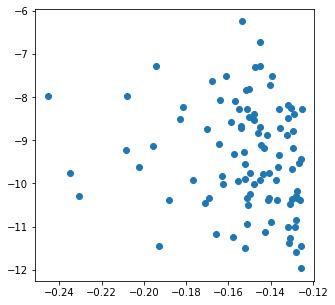




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std       	min         	max         
0  	250   	-7.34198e-07	6.6251e-06	-9.40555e-05	-2.73534e-16
1  	250   	-6.1789e-06 	7.00304e-05	-0.00110374 	-1.39186e-13
2  	250   	-4.04557e-06	2.20584e-05	-0.000254383	-4.47398e-13
3  	250   	-3.93985e-05	0.000206757	-0.0022838  	-4.74051e-13
4  	250   	-0.000471214	0.0054075  	-0.0843026  	-7.11753e-13
5  	250   	-4.36954e-05	0.000181089	-0.00189096 	-4.52357e-11
6  	250   	-0.00015186 	0.000610145	-0.00562608 	-4.09476e-10
7  	250   	-0.00025973 	0.00124909 	-0.0146041  	-3.07838e-09
8  	250   	-0.00042927 	0.00177022 	-0.0161893  	-3.47793e-09
9  	250   	-0.0006879  	0.00433815 	-0.0585669  	-2.64431e-08

N pep:  342
Best peptide: -12.200
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 026
N pep under -10 kcal/mol: 090
N pep under -9 kcal/mol: 141
N pep under -8 kcal/mol: 183
N pep under -7 kcal/mol: 232
N pep under -6 kcal/mol: 278
N pep under -5 kcal/mol: 342
Non binding pep        : 000


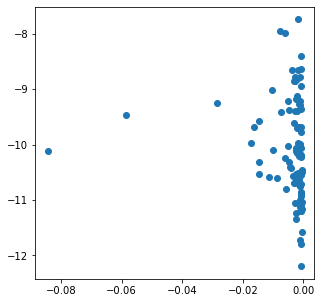




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std        	min         	max         
0  	250   	-1.8982e-06	2.86203e-05	-0.000453179	-2.97787e-19
1  	250   	-5.11643e-06	5.80562e-05	-0.00090004 	-6.69508e-18
2  	250   	-0.000389177	0.0059099  	-0.0936289  	-1.37718e-14
3  	250   	-0.00025412 	0.00385654 	-0.0611049  	-1.85624e-13
4  	250   	-0.000142287	0.00141208 	-0.022025   	-1.77338e-12
5  	250   	-0.000166784	0.00112667 	-0.0132913  	-5.86559e-11
6  	250   	-0.000245954	0.0015979  	-0.0215914  	-4.74574e-10
7  	250   	-0.000157523	0.000549582	-0.00643138 	-1.77466e-10
8  	250   	-0.000191974	0.00070904 	-0.00686592 	-1.07457e-09
9  	250   	-0.000237838	0.000876931	-0.0087031  	-1.72916e-09

N pep:  438
Best peptide: -12.698
N pep under -12 kcal/mol: 004
N pep under -11 kcal/mol: 056
N pep under -10 kcal/mol: 166
N pep under -9 kcal/mol: 236
N pep under -8 kcal/mol: 279
N pep under -7 kcal/mol: 328
N pep under -6 kcal/mol: 374
N pep under -5 kcal/mol: 438
Non binding pep        : 000


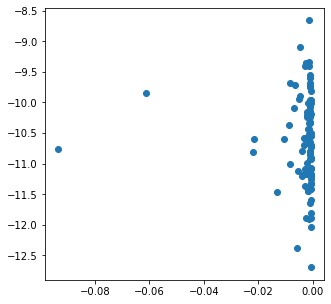




Run: 2
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.116
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 006
N pep under -7 kcal/mol: 031
N pep under -6 kcal/mol: 091
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std      	min       	max         
0  	250   	-0.00434583	0.0043539	-0.0298661	-0.000433066
1  	250   	-0.00666422	0.00680284	-0.0497244	-0.00057473 
2  	250   	-0.00934003	0.00744409	-0.0434359	-0.00122101 
3  	250   	-0.0120597 	0.00919592	-0.0576931	-0.00103189 
4  	250   	-0.0158402 	0.00992291	-0.0572907	-0.00190373 
5  	250   	-0.0173341 	0.0108909 	-0.0633355	-0.00244145 
6  	250   	-0.0210206 	0.013194  	-0.0950855	-0.00303528 
7  	250   	-0.0224186 	0.0140759 	-0.0887823	-0.00348318 
8  	250   	-0.0233276 	0.0131855 	-0.0728765	-0.00507898 
9  	250   	-0.027478  	0.0145644 	-0.0738   	-0.0034748  

N pep:  246
Best peptide: -11.252
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 004
N pep under -10 kcal/mol: 027
N pep under -9 kcal/mol: 051
N pep under -8 kcal/mol: 077
N pep under -7 kcal/mol: 113
N pep under -6 kcal/mol: 186
N pep under -5 kcal/mol: 246
Non binding pep        : 000


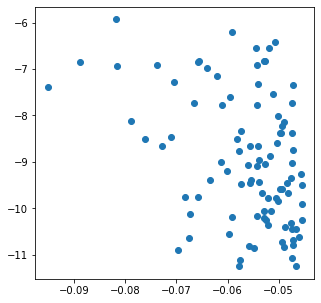




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std        	min         	max        
0  	250   	-7.57423e-07	4.05476e-06	-4.15922e-05	-4.0223e-12
1  	250   	-0.000115735	0.00169417 	-0.0268343  	-1.31403e-12
2  	250   	-4.76229e-05	0.000365146	-0.00489267 	-7.35409e-12
3  	250   	-0.00012689 	0.000784883	-0.00979196 	-4.94462e-11
4  	250   	-0.000279787	0.00253195 	-0.0393604  	-4.10843e-10
5  	250   	-0.00034497 	0.0015067  	-0.0163819  	-1.56842e-09
6  	250   	-0.000362423	0.00116669 	-0.00926868 	-1.38281e-09
7  	250   	-0.00131781 	0.00552691 	-0.0577015  	-8.85272e-10
8  	250   	-0.001377   	0.00477587 	-0.0481296  	-1.43257e-08
9  	250   	-0.00154555 	0.00589202 	-0.051274   	-1.69962e-08

N pep:  342
Best peptide: -11.718
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 017
N pep under -10 kcal/mol: 079
N pep under -9 kcal/mol: 138
N pep under -8 kcal/mol: 173
N pep under -7 kcal/mol: 209
N pep under -6 kcal/mol: 282
N pep under -5 kcal/mol: 342
Non binding pep        : 000


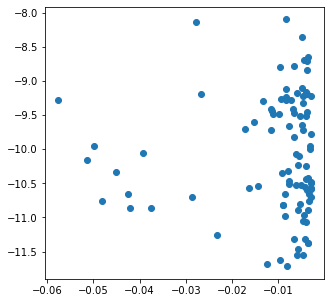




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std       	min         	max         
0  	250   	-3.56162e-06	4.1859e-05	-0.000630503	-1.17896e-14
1  	250   	-6.41336e-06	3.95765e-05	-0.000385843	-1.28899e-16
2  	250   	-5.44727e-05	0.000380453	-0.00436861 	-6.23912e-13
3  	250   	-0.00341226 	0.0316959  	-0.358285   	-7.81048e-16
4  	250   	-0.00045315 	0.00388456 	-0.0603588  	-2.62258e-11
5  	250   	-0.000816731	0.00576704 	-0.0841318  	-5.23372e-10
6  	250   	-0.00171701 	0.0199485  	-0.314476   	-1.55982e-09
7  	250   	-0.00154907 	0.00789565 	-0.105773   	-1.17827e-10
8  	250   	-0.00330844 	0.016374   	-0.216024   	-5.17973e-09
9  	250   	-0.00374702 	0.0209222  	-0.292156   	-1.59925e-07

N pep:  438
Best peptide: -12.912
N pep under -12 kcal/mol: 009
N pep under -11 kcal/mol: 047
N pep under -10 kcal/mol: 155
N pep under -9 kcal/mol: 232
N pep under -8 kcal/mol: 269
N pep under -7 kcal/mol: 305
N pep under -6 kcal/mol: 378
N pep under -5 kcal/mol: 438
Non binding pep        : 000


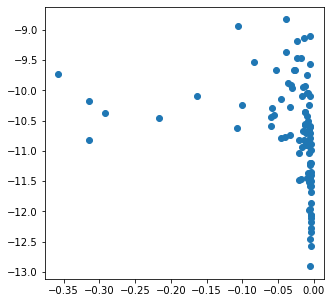




Run: 3
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.158
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 010
N pep under -7 kcal/mol: 039
N pep under -6 kcal/mol: 094
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std       	min       	max         
0  	250   	-0.00608686	0.00581976	-0.0507035	-0.000336567
1  	250   	-0.00946954	0.00802711	-0.0718523	-0.000962098
2  	250   	-0.0139911 	0.00991914	-0.0536715	-0.00169352 
3  	250   	-0.0168395 	0.0095635 	-0.0549539	-0.00192809 
4  	250   	-0.0209315 	0.0113547 	-0.0787283	-0.00311241 
5  	250   	-0.0240795 	0.0115367 	-0.0654541	-0.00412008 
6  	250   	-0.0269604 	0.0133732 	-0.0688322	-0.00522961 
7  	250   	-0.031759  	0.0146441 	-0.0860388	-0.00719102 
8  	250   	-0.0335019 	0.0136564 	-0.0805382	-0.00722776 
9  	250   	-0.0344129 	0.0146511 	-0.0917341	-0.0106646  

N pep:  246
Best peptide: -12.463
N pep under -12 kcal/mol: 002
N pep under -11 kcal/mol: 013
N pep under -10 kcal/mol: 040
N pep under -9 kcal/mol: 062
N pep under -8 kcal/mol: 099
N pep under -7 kcal/mol: 135
N pep under -6 kcal/mol: 190
N pep under -5 kcal/mol: 246
Non binding pep        : 000


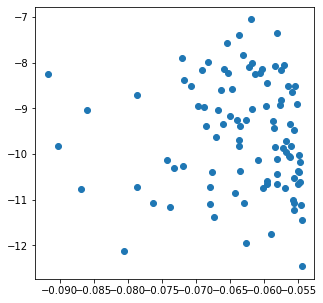




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std        	min         	max         
0  	250   	-1.31618e-08	1.17122e-07	-1.75575e-06	-1.34549e-17
1  	250   	-3.46717e-07	4.66194e-06	-7.3622e-05 	-5.71347e-16
2  	250   	-1.77072e-05	0.000262583	-0.00415849 	-1.94701e-16
3  	250   	-3.07614e-05	0.000385566	-0.00606126 	-2.99394e-15
4  	250   	-1.52918e-05	0.000122007	-0.00170425 	-7.34268e-16
5  	250   	-7.62885e-05	0.000991626	-0.0156383  	-7.9394e-13 
6  	250   	-1.87665e-05	0.000116243	-0.00118434 	-2.47415e-11
7  	250   	-7.09792e-05	0.000446289	-0.00562783 	-6.35317e-11
8  	250   	-0.000201652	0.00271696 	-0.0430216  	-1.68654e-10
9  	250   	-5.89654e-05	0.000256088	-0.00292913 	-8.41985e-10

N pep:  342
Best peptide: -12.463
N pep under -12 kcal/mol: 003
N pep under -11 kcal/mol: 032
N pep under -10 kcal/mol: 090
N pep under -9 kcal/mol: 141
N pep under -8 kcal/mol: 192
N pep under -7 kcal/mol: 231
N pep under -6 kcal/mol: 286
N pep under -5 kcal/mol: 342
Non binding pep        : 000


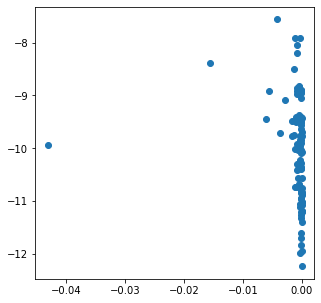




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std        	min         	max        
0  	250   	-1.93083e-08	1.92505e-07	-2.85734e-06	-2.2691e-20
1  	250   	-1.13426e-06	9.41254e-06	-0.000119739	-2.55791e-19
2  	250   	-8.51176e-07	6.12103e-06	-8.074e-05  	-2.48636e-17
3  	250   	-4.68151e-05	0.000606487	-0.00950961 	-2.77774e-16
4  	250   	-1.15093e-05	7.69419e-05	-0.000828579	-1.17597e-13
5  	250   	-2.50953e-06	1.11766e-05	-0.000113497	-2.61495e-14
6  	250   	-0.000201992	0.00260678 	-0.0411726  	-2.56434e-13
7  	250   	-4.00162e-05	0.000183174	-0.00141714 	-1.85305e-13
8  	250   	-0.000161753	0.00120346 	-0.0132501  	-1.23181e-12
9  	250   	-8.65902e-05	0.000388552	-0.00391147 	-1.18807e-11

N pep:  438
Best peptide: -12.463
N pep under -12 kcal/mol: 008
N pep under -11 kcal/mol: 070
N pep under -10 kcal/mol: 164
N pep under -9 kcal/mol: 235
N pep under -8 kcal/mol: 288
N pep under -7 kcal/mol: 327
N pep under -6 kcal/mol: 382
N pep under -5 kcal/mol: 438
Non binding pep        : 000


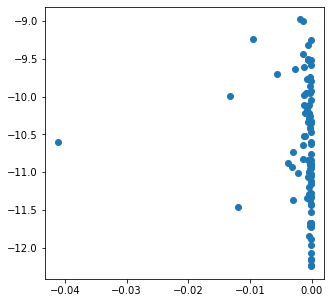




Run: 4
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.178
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 006
N pep under -7 kcal/mol: 042
N pep under -6 kcal/mol: 084
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std       	min       	max         
0  	250   	-0.00708399	0.00545705	-0.0290996	-0.000507119
1  	250   	-0.0119487 	0.0072306 	-0.040464 	-0.00074521 
2  	250   	-0.0164488 	0.00903994	-0.051943 	-0.00376152 
3  	250   	-0.0211024 	0.00908748	-0.0559403	-0.00336704 
4  	250   	-0.0233267 	0.0101057 	-0.0588991	-0.0064458  
5  	250   	-0.0253646 	0.0109793 	-0.0623153	-0.00529362 
6  	250   	-0.0286989 	0.0117111 	-0.0734396	-0.0076651  
7  	250   	-0.0313834 	0.0118331 	-0.0959973	-0.0106939  
8  	250   	-0.0317497 	0.009394  	-0.062695 	-0.0116932  
9  	250   	-0.0332065 	0.0108531 	-0.070069 	-0.0122634  

N pep:  246
Best peptide: -11.550
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 007
N pep under -10 kcal/mol: 027
N pep under -9 kcal/mol: 062
N pep under -8 kcal/mol: 086
N pep under -7 kcal/mol: 131
N pep under -6 kcal/mol: 179
N pep under -5 kcal/mol: 246
Non binding pep        : 000


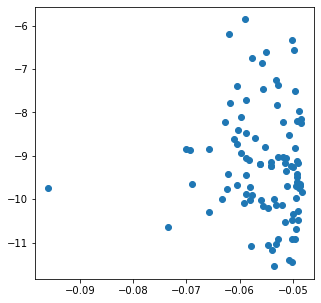




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std        	min         	max        
0  	250   	-9.21191e-07	3.85605e-06	-3.72504e-05	-1.1608e-12
1  	250   	-1.55779e-05	0.000127323	-0.00192321 	-5.91806e-13
2  	250   	-5.95222e-05	0.000391324	-0.00437682 	-2.58621e-11
3  	250   	-0.000755618	0.00691701 	-0.0825746  	-9.35825e-10
4  	250   	-0.000202922	0.000890191	-0.00984222 	-6.61714e-09
5  	250   	-0.000430522	0.00138416 	-0.0119786  	-1.30743e-09
6  	250   	-0.000783004	0.00322182 	-0.0286116  	-6.56878e-08
7  	250   	-0.000946948	0.00226786 	-0.0174384  	-1.82918e-07
8  	250   	-0.00187364 	0.00962043 	-0.125153   	-4.36307e-07
9  	250   	-0.00147824 	0.00499254 	-0.0498903  	-2.05519e-08

N pep:  342
Best peptide: -12.352
N pep under -12 kcal/mol: 004
N pep under -11 kcal/mol: 033
N pep under -10 kcal/mol: 089
N pep under -9 kcal/mol: 142
N pep under -8 kcal/mol: 177
N pep under -7 kcal/mol: 227
N pep under -6 kcal/mol: 275
N pep under -5 kcal/mol: 342
Non binding pep        : 000


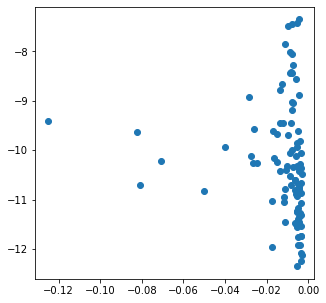




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std        	min         	max         
0  	250   	-4.36516e-07	4.84715e-06	-7.44927e-05	-3.02887e-18
1  	250   	-2.43042e-06	2.12524e-05	-0.000322075	-3.8612e-16 
2  	250   	-2.09131e-05	0.000273236	-0.0043229  	-7.32534e-13
3  	250   	-1.82728e-05	0.000111388	-0.00139534 	-7.2366e-14 
4  	250   	-3.62369e-05	0.000199869	-0.00229049 	-4.13458e-12
5  	250   	-4.85033e-05	0.000256257	-0.00343593 	-2.71291e-10
6  	250   	-0.000222996	0.00229434 	-0.0353475  	-2.2691e-10 
7  	250   	-0.000212985	0.00140283 	-0.020021   	-3.44574e-10
8  	250   	-0.000314364	0.00163224 	-0.0193979  	-2.09546e-09
9  	250   	-0.000307492	0.00181155 	-0.0251991  	-3.13873e-09

N pep:  438
Best peptide: -12.352
N pep under -12 kcal/mol: 008
N pep under -11 kcal/mol: 065
N pep under -10 kcal/mol: 163
N pep under -9 kcal/mol: 234
N pep under -8 kcal/mol: 273
N pep under -7 kcal/mol: 323
N pep under -6 kcal/mol: 371
N pep under -5 kcal/mol: 438
Non binding pep        : 000


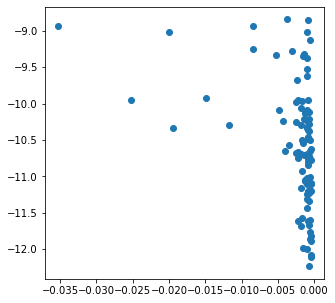




Run: 5
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.178
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 004
N pep under -7 kcal/mol: 039
N pep under -6 kcal/mol: 096
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std       	min        	max       
0  	250   	-0.00419585	0.00122444	-0.00882848	-0.0014005
1  	250   	-0.00508038	0.00143474	-0.0106013 	-0.00217168
2  	250   	-0.00575744	0.00143125	-0.0108564 	-0.00236468
3  	250   	-0.00642116	0.0013294 	-0.0108226 	-0.00373107
4  	250   	-0.00714203	0.00144247	-0.0109479 	-0.00345136
5  	250   	-0.00753208	0.001348  	-0.0115816 	-0.00391512
6  	250   	-0.00818915	0.00148821	-0.0130515 	-0.00470894
7  	250   	-0.00844239	0.00144581	-0.0129182 	-0.00496903
8  	250   	-0.00875011	0.00127217	-0.0131914 	-0.00587704
9  	250   	-0.00888238	0.00125554	-0.01258   	-0.00587976

N pep:  246
Best peptide: -12.362
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 007
N pep under -10 kcal/mol: 027
N pep under -9 kcal/mol: 051
N pep under -8 kcal/mol: 083
N pep under -7 kcal/mol: 134
N pep under -6 kcal/mol: 192
N pep under -5 kcal/mol: 246
Non binding pep        : 000


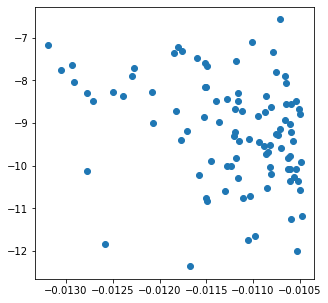




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std        	min         	max         
0  	250   	-1.38908e-07	1.37155e-06	-2.09009e-05	-1.84936e-15
1  	250   	-1.66377e-07	1.00112e-06	-9.34071e-06	-4.6838e-15 
2  	250   	-1.97254e-06	2.05221e-05	-0.000317306	-8.71716e-14
3  	250   	-1.95254e-05	0.000192145	-0.00286159 	-2.44747e-13
4  	250   	-5.6756e-06 	4.55244e-05	-0.000685313	-4.77073e-12
5  	250   	-2.12866e-05	0.000110631	-0.00121889 	-3.46745e-12
6  	250   	-3.32056e-05	0.000188531	-0.0026287  	-8.02198e-11
7  	250   	-6.19881e-05	0.000366845	-0.00466206 	-4.11876e-11
8  	250   	-0.000123569	0.000687268	-0.00937977 	-1.68683e-12
9  	250   	-0.00012693 	0.000771731	-0.0114026  	-3.00718e-10

N pep:  342
Best peptide: -12.362
N pep under -12 kcal/mol: 006
N pep under -11 kcal/mol: 045
N pep under -10 kcal/mol: 102
N pep under -9 kcal/mol: 143
N pep under -8 kcal/mol: 179
N pep under -7 kcal/mol: 230
N pep under -6 kcal/mol: 288
N pep under -5 kcal/mol: 342
Non binding pep        : 000


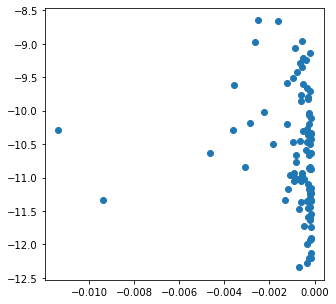




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std        	min        	max         
0  	250   	-2.03384e-06	3.11578e-05	-0.00049363	-4.22995e-17
1  	250   	-1.81842e-06	1.87568e-05	-0.000267387	-4.57732e-15
2  	250   	-8.17959e-05	0.000921344	-0.0128201  	-1.63134e-14
3  	250   	-9.46411e-05	0.00120988 	-0.019116   	-1.12626e-12
4  	250   	-0.000467512	0.00651816 	-0.103058   	-4.7203e-13 
5  	250   	-9.81159e-05	0.000610475	-0.00844831 	-3.35591e-11
6  	250   	-0.000256844	0.00160192 	-0.0161706  	-3.10269e-11
7  	250   	-0.000460666	0.00313442 	-0.0423762  	-3.36309e-11
8  	250   	-0.00032578 	0.00198841 	-0.0268438  	-1.04888e-10
9  	250   	-0.000770408	0.00735056 	-0.113258   	-3.73833e-13

N pep:  438
Best peptide: -12.592
N pep under -12 kcal/mol: 016
N pep under -11 kcal/mol: 083
N pep under -10 kcal/mol: 180
N pep under -9 kcal/mol: 236
N pep under -8 kcal/mol: 275
N pep under -7 kcal/mol: 326
N pep under -6 kcal/mol: 384
N pep under -5 kcal/mol: 438
Non binding pep        : 000


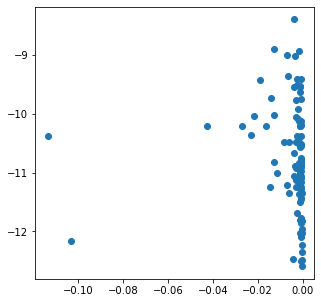




Run: 6
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.030
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 033
N pep under -6 kcal/mol: 086
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std       	min       	max         
0  	250   	-0.00339325	0.00210073	-0.0104042	-0.000462125
1  	250   	-0.0057642 	0.00272742	-0.0180305	-0.000762256
2  	250   	-0.00670197	0.00279239	-0.0206316	-0.0022546  
3  	250   	-0.00772854	0.00316705	-0.0205554	-0.00226182 
4  	250   	-0.00875354	0.00276051	-0.0196957	-0.00291039 
5  	250   	-0.00977213	0.00320665	-0.0192765	-0.00301276 
6  	250   	-0.0102179 	0.00340965	-0.0194206	-0.00270393 
7  	250   	-0.0116506 	0.00353837	-0.031893 	-0.00472092 
8  	250   	-0.0123157 	0.00324983	-0.0272674	-0.00557754 
9  	250   	-0.0127576 	0.00329595	-0.0255553	-0.00580029 

N pep:  246
Best peptide: -11.037
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 002
N pep under -10 kcal/mol: 012
N pep under -9 kcal/mol: 034
N pep under -8 kcal/mol: 067
N pep under -7 kcal/mol: 121
N pep under -6 kcal/mol: 179
N pep under -5 kcal/mol: 246
Non binding pep        : 000


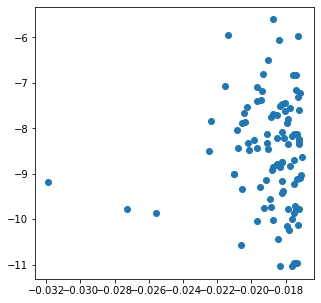




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std        	min         	max         
0  	250   	-7.6165e-07	7.23594e-06	-0.000112824	-5.89891e-15
1  	250   	-2.88847e-06	1.72704e-05	-0.000224008	-4.11069e-14
2  	250   	-1.19586e-05	6.32163e-05	-0.0008444  	-1.56153e-11
3  	250   	-2.06794e-05	0.000106014	-0.00143085 	-2.26893e-10
4  	250   	-8.06822e-05	0.000575519	-0.00789675 	-1.26842e-10
5  	250   	-0.000129588	0.000911271	-0.0108978  	-3.68569e-09
6  	250   	-0.000135184	0.000667141	-0.00706262 	-6.56617e-10
7  	250   	-0.00021171 	0.000901598	-0.00731771 	-5.33618e-10
8  	250   	-8.82154e-05	0.00030119 	-0.00344578 	-6.97471e-10
9  	250   	-0.00035472 	0.0024135  	-0.0364284  	-1.09085e-08

N pep:  342
Best peptide: -12.190
N pep under -12 kcal/mol: 002
N pep under -11 kcal/mol: 014
N pep under -10 kcal/mol: 049
N pep under -9 kcal/mol: 101
N pep under -8 kcal/mol: 153
N pep under -7 kcal/mol: 212
N pep under -6 kcal/mol: 275
N pep under -5 kcal/mol: 342
Non binding pep        : 000


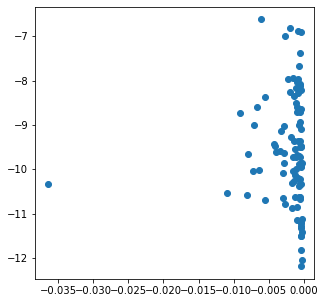




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std        	min         	max         
0  	250   	-5.55861e-08	6.65926e-07	-1.02063e-05	-3.21794e-18
1  	250   	-1.42562e-06	1.98049e-05	-0.00031364 	-5.05915e-18
2  	250   	-0.000260754	0.0036559  	-0.0577275  	-1.69284e-14
3  	250   	-1.76654e-05	0.000219944	-0.00346625 	-2.80316e-13
4  	250   	-2.96731e-05	0.00017729 	-0.00160376 	-3.59918e-12
5  	250   	-5.95076e-05	0.000671819	-0.0105713  	-4.78863e-12
6  	250   	-0.00020255 	0.0018029  	-0.0206863  	-7.92187e-13
7  	250   	-8.56543e-05	0.000779129	-0.0118786  	-1.39778e-11
8  	250   	-2.59595e-05	0.000149568	-0.00172388 	-7.39045e-11
9  	250   	-9.00233e-05	0.000449238	-0.00452726 	-3.16634e-11

N pep:  438
Best peptide: -12.246
N pep under -12 kcal/mol: 004
N pep under -11 kcal/mol: 035
N pep under -10 kcal/mol: 104
N pep under -9 kcal/mol: 188
N pep under -8 kcal/mol: 247
N pep under -7 kcal/mol: 308
N pep under -6 kcal/mol: 371
N pep under -5 kcal/mol: 438
Non binding pep        : 000


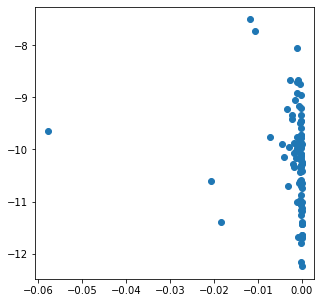




Run: 7
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.163
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 034
N pep under -6 kcal/mol: 077
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std       	min       	max         
0  	250   	-0.00345264	0.00301389	-0.0209195	-7.85227e-05
1  	250   	-0.00653139	0.0058503 	-0.0288766	-0.000279799
2  	250   	-0.00877762	0.00761328	-0.055063 	-0.000389494
3  	250   	-0.0127544 	0.00801364	-0.0518903	-0.00203324 
4  	250   	-0.0158567 	0.00882515	-0.0665726	-0.000641333
5  	250   	-0.0192601 	0.00923844	-0.0514401	-0.00266959 
6  	250   	-0.0226655 	0.0101174 	-0.0545025	-0.00546408 
7  	250   	-0.0238131 	0.00966834	-0.0597128	-0.00496028 
8  	250   	-0.027795  	0.0107141 	-0.069843 	-0.00606638 
9  	250   	-0.0278465 	0.011125  	-0.0694549	-0.00888596 

N pep:  246
Best peptide: -11.467
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 010
N pep under -9 kcal/mol: 031
N pep under -8 kcal/mol: 065
N pep under -7 kcal/mol: 115
N pep under -6 kcal/mol: 170
N pep under -5 kcal/mol: 244
Non binding pep        : 002


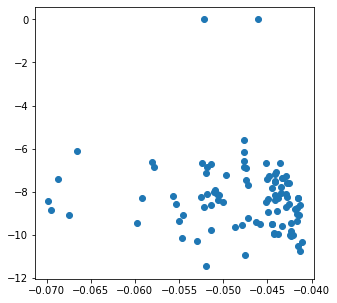




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std        	min         	max         
0  	250   	-5.98513e-06	5.35838e-05	-0.000822841	-3.02242e-12
1  	250   	-1.90518e-05	9.66962e-05	-0.00112983 	-8.03934e-12
2  	250   	-0.00013245 	0.000869982	-0.00883358 	-4.20601e-10
3  	250   	-0.000226066	0.00172768 	-0.0245714  	-8.77806e-09
4  	250   	-0.000121486	0.000491698	-0.00693217 	-1.39021e-08
5  	250   	-0.000187639	0.000657115	-0.00916286 	-5.77401e-08
6  	250   	-0.000439117	0.00124263 	-0.00976265 	-5.82152e-08
7  	250   	-0.000430401	0.00097662 	-0.010269   	-7.31865e-08
8  	250   	-0.000855575	0.00395605 	-0.0504801  	-1.01672e-06
9  	250   	-0.00114374 	0.00309521 	-0.0218449  	-7.21547e-07

N pep:  342
Best peptide: -12.595
N pep under -12 kcal/mol: 003
N pep under -11 kcal/mol: 017
N pep under -10 kcal/mol: 061
N pep under -9 kcal/mol: 109
N pep under -8 kcal/mol: 156
N pep under -7 kcal/mol: 211
N pep under -6 kcal/mol: 266
N pep under -5 kcal/mol: 340
Non binding pep        : 002


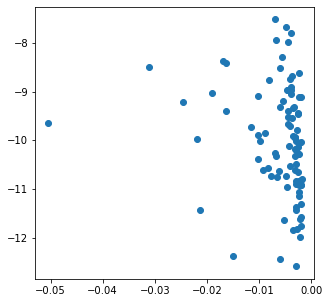




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std        	min         	max         
0  	250   	-7.95508e-08	5.39741e-07	-5.97244e-06	-6.70963e-18
1  	250   	-7.06716e-06	0.00010268 	-0.00162594 	-6.30836e-16
2  	250   	-1.15729e-06	5.19413e-06	-5.25517e-05	-7.1392e-13 
3  	250   	-2.18306e-05	0.000294785	-0.00466214 	-1.48838e-14
4  	250   	-2.26565e-05	0.000162616	-0.00209615 	-2.25365e-12
5  	250   	-5.80603e-05	0.000399618	-0.0048869  	-2.29484e-12
6  	250   	-9.2592e-05 	0.000640527	-0.00925244 	-4.26057e-12
7  	250   	-0.000127308	0.00052798 	-0.00454411 	-1.4115e-10 
8  	250   	-0.000222705	0.00107635 	-0.0112719  	-2.45169e-12
9  	250   	-0.000238612	0.00146174 	-0.0203829  	-1.6594e-10 

N pep:  438
Best peptide: -12.595
N pep under -12 kcal/mol: 004
N pep under -11 kcal/mol: 046
N pep under -10 kcal/mol: 139
N pep under -9 kcal/mol: 202
N pep under -8 kcal/mol: 252
N pep under -7 kcal/mol: 307
N pep under -6 kcal/mol: 362
N pep under -5 kcal/mol: 436
Non binding pep        : 002


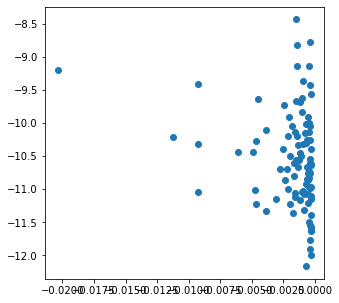




Run: 8
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.121
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 007
N pep under -7 kcal/mol: 035
N pep under -6 kcal/mol: 084
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std       	min       	max        
0  	250   	-0.00483882	0.00639054	-0.0385409	-1.4815e-05
1  	250   	-0.0101843 	0.0126588 	-0.106714 	-5.78744e-05
2  	250   	-0.0119208 	0.0136367 	-0.112346 	-0.000250483
3  	250   	-0.0159513 	0.0173974 	-0.104556 	-0.000412634
4  	250   	-0.0215119 	0.0217088 	-0.154915 	-0.000196582
5  	250   	-0.0278516 	0.0246442 	-0.167507 	-0.00211797 
6  	250   	-0.0315248 	0.0258102 	-0.196627 	-0.00173734 
7  	250   	-0.033157  	0.02775   	-0.194888 	-0.00127252 
8  	250   	-0.0371846 	0.0292759 	-0.179402 	-0.000983062
9  	250   	-0.0396608 	0.0279014 	-0.193644 	-0.00456852 

N pep:  246
Best peptide: -12.273
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 008
N pep under -10 kcal/mol: 017
N pep under -9 kcal/mol: 044
N pep under -8 kcal/mol: 079
N pep under -7 kcal/mol: 120
N pep under -6 kcal/mol: 177
N pep under -5 kcal/mol: 246
Non binding pep        : 000


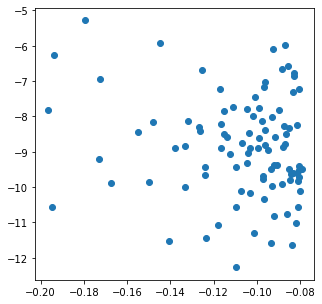




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std        	min         	max         
0  	250   	-1.96031e-07	1.45175e-06	-1.89304e-05	-1.06013e-16
1  	250   	-1.27327e-06	1.04807e-05	-0.000151466	-8.43302e-16
2  	250   	-4.80617e-05	0.000585533	-0.00914353 	-6.26605e-13
3  	250   	-3.46062e-06	1.16246e-05	-0.000105004	-1.58981e-11
4  	250   	-3.24588e-05	0.000270371	-0.00394883 	-4.71861e-12
5  	250   	-2.79029e-05	0.000137156	-0.00133834 	-5.82731e-13
6  	250   	-3.50407e-05	0.000304064	-0.00466244 	-1.16305e-11
7  	250   	-9.38658e-05	0.000679774	-0.00874842 	-1.0099e-10 
8  	250   	-0.000230844	0.00241457 	-0.0368963  	-7.70882e-13
9  	250   	-0.000160639	0.00102957 	-0.0119722  	-9.01746e-11

N pep:  342
Best peptide: -13.202
N pep under -12 kcal/mol: 006
N pep under -11 kcal/mol: 032
N pep under -10 kcal/mol: 072
N pep under -9 kcal/mol: 124
N pep under -8 kcal/mol: 174
N pep under -7 kcal/mol: 216
N pep under -6 kcal/mol: 273
N pep under -5 kcal/mol: 342
Non binding pep        : 000


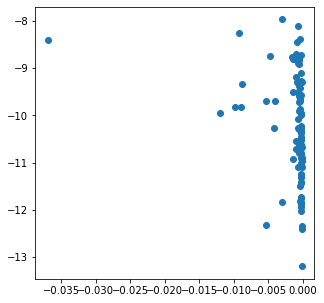




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std        	min         	max         
0  	250   	-4.7647e-09	6.14389e-08	-9.68149e-07	-3.69974e-19
1  	250   	-1.86045e-07	1.75555e-06	-2.08482e-05	-7.08849e-20
2  	250   	-1.3065e-06 	1.55387e-05	-0.000242495	-6.49938e-18
3  	250   	-3.66369e-06	3.6538e-05 	-0.000532204	-2.11024e-14
4  	250   	-6.82091e-06	9.51008e-05	-0.0015054  	-3.71059e-15
5  	250   	-2.84524e-05	0.000271573	-0.00413291 	-1.01778e-13
6  	250   	-1.06135e-05	6.44146e-05	-0.00066821 	-4.50605e-15
7  	250   	-0.000153939	0.00153518 	-0.0220392  	-1.06575e-12
8  	250   	-0.000246533	0.00284585 	-0.0446027  	-3.79616e-12
9  	250   	-0.000203073	0.000919414	-0.0104111  	-4.2106e-11 

N pep:  438
Best peptide: -13.202
N pep under -12 kcal/mol: 016
N pep under -11 kcal/mol: 082
N pep under -10 kcal/mol: 162
N pep under -9 kcal/mol: 219
N pep under -8 kcal/mol: 270
N pep under -7 kcal/mol: 312
N pep under -6 kcal/mol: 369
N pep under -5 kcal/mol: 438
Non binding pep        : 000


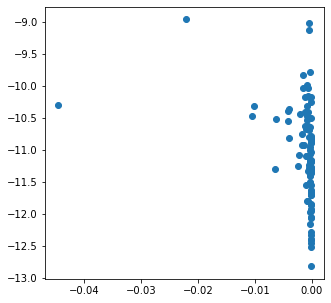




Run: 9
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.141
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 004
N pep under -7 kcal/mol: 034
N pep under -6 kcal/mol: 084
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std       	min       	max         
0  	250   	-0.00620634	0.00860454	-0.0567111	-5.80949e-05
1  	250   	-0.0144329 	0.0167364 	-0.122112 	-8.21077e-05
2  	250   	-0.0236389 	0.0207794 	-0.12569  	-0.00130897 
3  	250   	-0.0293022 	0.0242578 	-0.183227 	-0.00222793 
4  	250   	-0.0372303 	0.0261494 	-0.163036 	-0.00383183 
5  	250   	-0.0422019 	0.0299252 	-0.163074 	-0.00357311 
6  	250   	-0.0506504 	0.0339138 	-0.284147 	-0.00564737 
7  	250   	-0.0505775 	0.0325172 	-0.211652 	-0.00465723 
8  	250   	-0.0549038 	0.0301284 	-0.190062 	-0.00643883 
9  	250   	-0.0646246 	0.035707  	-0.174334 	-0.00922834 

N pep:  246
Best peptide: -12.066
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 006
N pep under -10 kcal/mol: 028
N pep under -9 kcal/mol: 067
N pep under -8 kcal/mol: 093
N pep under -7 kcal/mol: 130
N pep under -6 kcal/mol: 180
N pep under -5 kcal/mol: 246
Non binding pep        : 000


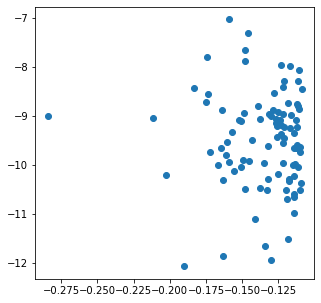




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std       	min        	max        
0  	250   	-1.41196e-07	9.1164e-07	-1.1162e-05	-3.1233e-16
1  	250   	-7.93415e-07	5.99484e-06	-8.55285e-05	-1.87236e-17
2  	250   	-9.70295e-06	7.26647e-05	-0.00100701 	-7.43707e-14
3  	250   	-3.41675e-05	0.000306877	-0.00382246 	-8.30751e-12
4  	250   	-2.29118e-05	0.00013831 	-0.00201798 	-4.05738e-11
5  	250   	-7.59505e-05	0.000325799	-0.00292684 	-5.68765e-10
6  	250   	-0.000115553	0.000646041	-0.00924998 	-1.56988e-10
7  	250   	-0.00017078 	0.000823714	-0.0113852  	-9.36135e-10
8  	250   	-9.63195e-05	0.000309107	-0.00274891 	-1.28031e-10
9  	250   	-0.000252422	0.00131935 	-0.0165405  	-7.18609e-09

N pep:  342
Best peptide: -12.336
N pep under -12 kcal/mol: 006
N pep under -11 kcal/mol: 038
N pep under -10 kcal/mol: 097
N pep under -9 kcal/mol: 160
N pep under -8 kcal/mol: 188
N pep under -7 kcal/mol: 226
N pep under -6 kcal/mol: 276
N pep under -5 kcal/mol: 342
Non binding pep        : 000


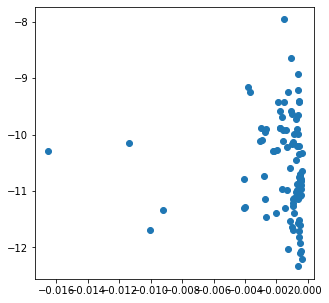




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std        	min         	max         
0  	250   	-1.52328e-07	1.66356e-06	-2.53476e-05	-9.97205e-22
1  	250   	-1.03442e-05	9.90168e-05	-0.00133913 	-3.95984e-18
2  	250   	-2.10891e-05	0.000297521	-0.00471315 	-3.25329e-15
3  	250   	-7.25902e-06	4.6674e-05 	-0.00042788 	-4.16725e-16
4  	250   	-3.19051e-05	0.000179358	-0.00216368 	-5.24841e-15
5  	250   	-0.000264533	0.0018377  	-0.0223065  	-3.31087e-13
6  	250   	-7.93752e-05	0.00042818 	-0.0045676  	-5.11545e-13
7  	250   	-0.000155212	0.00138745 	-0.021092   	-2.0934e-11 
8  	250   	-0.000812736	0.00832309 	-0.122138   	-1.40934e-11
9  	250   	-0.000386865	0.00286464 	-0.0436382  	-3.06102e-11

N pep:  438
Best peptide: -12.336
N pep under -12 kcal/mol: 009
N pep under -11 kcal/mol: 062
N pep under -10 kcal/mol: 174
N pep under -9 kcal/mol: 256
N pep under -8 kcal/mol: 284
N pep under -7 kcal/mol: 322
N pep under -6 kcal/mol: 372
N pep under -5 kcal/mol: 438
Non binding pep        : 000


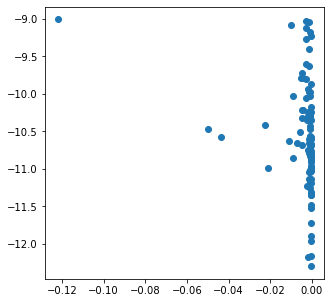




Run: 10
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.182
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 006
N pep under -7 kcal/mol: 046
N pep under -6 kcal/mol: 095
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std        	min        	max        
0  	250   	-0.0075661	9.81694e-08	-0.00756636	-0.00756578
1  	250   	-0.00756616	9.44977e-08	-0.00756645	-0.0075659 
2  	250   	-0.0075662 	8.22519e-08	-0.00756642	-0.00756595
3  	250   	-0.00756623	7.58941e-08	-0.00756648	-0.00756607
4  	250   	-0.00756624	7.64099e-08	-0.00756649	-0.00756602
5  	250   	-0.00756626	7.50982e-08	-0.00756651	-0.0075661 
6  	250   	-0.00756628	7.59788e-08	-0.0075665 	-0.00756607
7  	250   	-0.00756629	7.4318e-08 	-0.00756648	-0.00756611
8  	250   	-0.0075663 	6.97443e-08	-0.00756648	-0.00756611
9  	250   	-0.00756632	6.73789e-08	-0.00756649	-0.00756611

N pep:  246
Best peptide: -11.591
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 002
N pep under -10 kcal/mol: 018
N pep under -9 kcal/mol: 035
N pep under -8 kcal/mol: 060
N pep under -7 kcal/mol: 122
N pep under -6 kcal/mol: 185
N pep under -5 kcal/mol: 246
Non binding pep        : 000


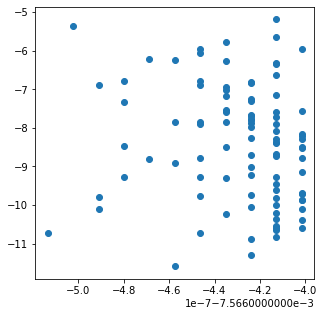




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std        	min         	max         
0  	250   	-4.38156e-06	2.20072e-05	-0.000238941	-1.93194e-11
1  	250   	-3.70401e-05	0.000322192	-0.00493201 	-8.22654e-12
2  	250   	-4.12857e-05	0.000172718	-0.00191707 	-3.95728e-11
3  	250   	-0.000138933	0.000600712	-0.00734909 	-2.00164e-09
4  	250   	-0.000247943	0.00213919 	-0.0336195  	-2.36098e-09
5  	250   	-0.000485587	0.0034238  	-0.0409874  	-2.69188e-08
6  	250   	-0.000281821	0.00131239 	-0.0195262  	-1.37512e-08
7  	250   	-0.000466485	0.00175994 	-0.0173095  	-2.44283e-07
8  	250   	-0.000486022	0.00160547 	-0.0205871  	-5.76315e-07
9  	250   	-0.000503369	0.00145472 	-0.0150249  	-4.29004e-07

N pep:  342
Best peptide: -12.182
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 018
N pep under -10 kcal/mol: 070
N pep under -9 kcal/mol: 115
N pep under -8 kcal/mol: 154
N pep under -7 kcal/mol: 218
N pep under -6 kcal/mol: 281
N pep under -5 kcal/mol: 342
Non binding pep        : 000


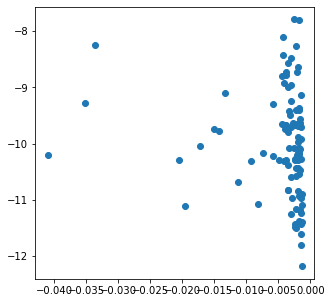




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std       	min         	max         
0  	250   	-1.22481e-06	1.0257e-05	-0.000144276	-1.23953e-15
1  	250   	-1.36833e-05	0.00012995	-0.00165617 	-1.35169e-14
2  	250   	-2.91612e-05	0.000303274	-0.00468418 	-1.46389e-12
3  	250   	-4.57105e-05	0.000270408	-0.00398271 	-3.27026e-12
4  	250   	-0.000497459	0.003865   	-0.055754   	-5.37405e-11
5  	250   	-0.000434365	0.00265701 	-0.0263695  	-5.17285e-10
6  	250   	-0.000322326	0.00204079 	-0.0265247  	-6.21954e-10
7  	250   	-0.000294633	0.00143515 	-0.0143054  	-1.17149e-09
8  	250   	-0.000645948	0.00454544 	-0.0446356  	-4.84782e-09
9  	250   	-0.000613206	0.00313889 	-0.0370524  	-1.54131e-09

N pep:  438
Best peptide: -13.018
N pep under -12 kcal/mol: 005
N pep under -11 kcal/mol: 055
N pep under -10 kcal/mol: 148
N pep under -9 kcal/mol: 207
N pep under -8 kcal/mol: 250
N pep under -7 kcal/mol: 314
N pep under -6 kcal/mol: 377
N pep under -5 kcal/mol: 438
Non binding pep        : 000


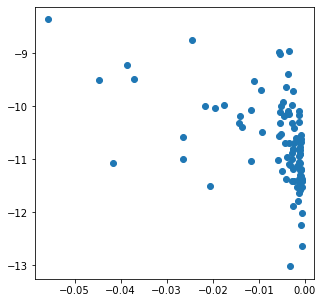

In [63]:
pbil_candidate_fps = []
pbil_candidate_y = []

n_peptides = 150
peptide_length = 9
energy_bounds = [-8.2, -5] # about between 1 and 250 uM
energy_cutoff = -5 # around 250 uM

for i in range(10):
    print('Run: %s' % (i + 1))
    
    # Generate random peptides
    random_peptides, random_peptide_scores = generate_random_peptides(n_peptides, peptide_length, pssm, reg,
                                                                      energy_bounds, energy_cutoff)
    
    # Compute the MAP4 fingerprint for all the peptides
    X_fps_exp = map4_fingerprint(random_peptides)
    y_exp = torch.from_numpy(random_peptide_scores).float()
    print('Exp dataset size: (%d, %d)' % (X_fps_exp.shape[0], X_fps_exp.shape[1]))
    
    print('\n')
    
    print('Init.')
    print('N pep: ', X_fps_exp.shape[0])
    print('Best peptide: %.3f' % y_exp.min())
    for n in [-12, -11, -10, -9, -8, -7, -6, -5]:
        print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
    print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))

    print('\n\n')

    for j in range(3):
        print('Generation: %d' % (j + 1))
        # Train GP model
        model = get_fitted_model(X_fps_exp, y_exp, kernel=TanimotoSimilarityKernel)

        # Find new candidates
        #acq = AcqScoring(model, probability_of_improvement, y_exp)
        acq = AcqScoring(model, expected_improvement, y_exp)
        candidate_sequences, candidates_acq = find_next_candidates(acq, greater_is_better=False)

        # Add candidates to the training set
        candidate_fps = map4_fingerprint(candidate_sequences)
        y_candidates = torch.from_numpy(np.array(predict_peptide_affinity_binding(candidate_sequences, pssm, reg)))

        X_fps_exp = torch.cat([X_fps_exp, candidate_fps])
        y_exp = torch.cat([y_exp, y_candidates])

        print('')
        print('N pep: ', X_fps_exp.shape[0])
        print('Best peptide: %.3f' % y_exp.min())
        for n in [-12, -11, -10, -9, -8,  -7, -6, -5]:
            print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
        print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.scatter(candidates_acq, y_candidates.numpy())
        plt.show()

        print('\n\n')
    
    
    pbil_candidate_fps.append(X_fps_exp.detach().numpy())
    pbil_candidate_y.append(y_exp.detach().numpy())


pbil_candidate_fps = np.array(pbil_candidate_fps)
pbil_candidate_y = np.array(pbil_candidate_y)

### Random candidate peptides sampling

In [60]:
def find_next_candidates_by_random(scorer, greater_is_better=True):
    NGEN = 10
    NIND = 250
    NBEST = 50
    NLEN = 9
    NCAN = 96
    AA1 = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
    
    sequences = np.array([''.join(s) for s in np.random.choice(AA1, (NGEN * NIND, NLEN))])
    
    sequence_acqs = scorer.evaluate(sequences)
    
    if greater_is_better:
        sorted_peptide_indices = np.argsort(np.ravel(sequence_acqs))[::-1]
    else:
        sorted_peptide_indices = np.argsort(np.ravel(sequence_acqs))
            
    candidates = sequences[sorted_peptide_indices[:NCAN]]
    candidate_acqs = sequence_acqs[sorted_peptide_indices[:NCAN]]
                        
    return candidates, candidate_acqs

Run: 1
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.159
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 002
N pep under -7 kcal/mol: 044
N pep under -6 kcal/mol: 089
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.187
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 006
N pep under -8 kcal/mol: 021
N pep under -7 kcal/mol: 082
N pep under -6 kcal/mol: 146
N pep under -5 kcal/mol: 224
Non binding pep        : 022


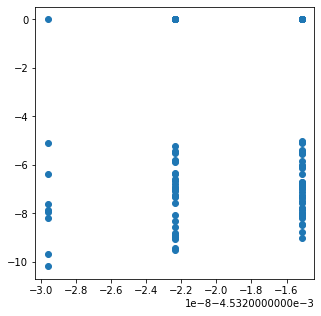




Generation: 2

N pep:  342
Best peptide: -12.450
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 011
N pep under -9 kcal/mol: 032
N pep under -8 kcal/mol: 079
N pep under -7 kcal/mol: 165
N pep under -6 kcal/mol: 239
N pep under -5 kcal/mol: 320
Non binding pep        : 022


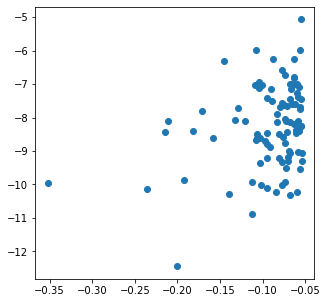




Generation: 3

N pep:  438
Best peptide: -12.450
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 004
N pep under -10 kcal/mol: 025
N pep under -9 kcal/mol: 074
N pep under -8 kcal/mol: 146
N pep under -7 kcal/mol: 248
N pep under -6 kcal/mol: 334
N pep under -5 kcal/mol: 416
Non binding pep        : 022


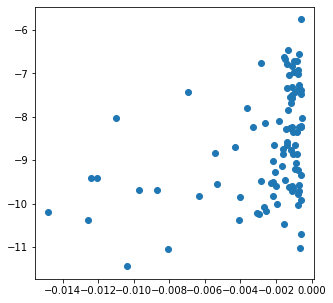




Run: 2
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.183
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 007
N pep under -7 kcal/mol: 036
N pep under -6 kcal/mol: 082
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.954
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 004
N pep under -9 kcal/mol: 012
N pep under -8 kcal/mol: 044
N pep under -7 kcal/mol: 095
N pep under -6 kcal/mol: 162
N pep under -5 kcal/mol: 242
Non binding pep        : 004


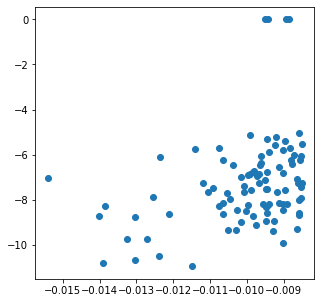




Generation: 2

N pep:  342
Best peptide: -12.456
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 011
N pep under -9 kcal/mol: 044
N pep under -8 kcal/mol: 105
N pep under -7 kcal/mol: 179
N pep under -6 kcal/mol: 258
N pep under -5 kcal/mol: 338
Non binding pep        : 004


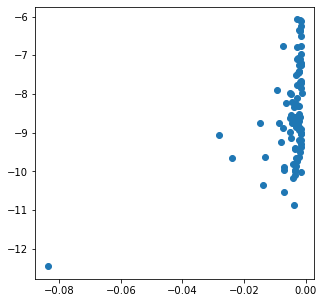




Generation: 3

N pep:  438
Best peptide: -12.456
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 003
N pep under -10 kcal/mol: 022
N pep under -9 kcal/mol: 079
N pep under -8 kcal/mol: 174
N pep under -7 kcal/mol: 267
N pep under -6 kcal/mol: 353
N pep under -5 kcal/mol: 434
Non binding pep        : 004


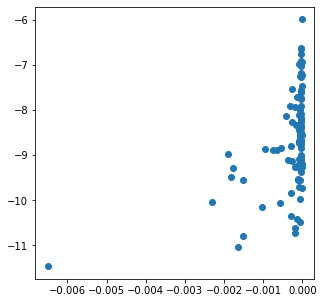




Run: 3
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.186
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 006
N pep under -7 kcal/mol: 035
N pep under -6 kcal/mol: 089
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.782
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 004
N pep under -9 kcal/mol: 013
N pep under -8 kcal/mol: 038
N pep under -7 kcal/mol: 086
N pep under -6 kcal/mol: 169
N pep under -5 kcal/mol: 240
Non binding pep        : 006


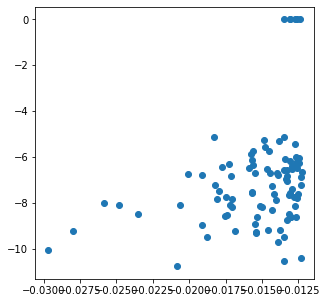




Generation: 2

N pep:  342
Best peptide: -11.406
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 004
N pep under -10 kcal/mol: 012
N pep under -9 kcal/mol: 045
N pep under -8 kcal/mol: 093
N pep under -7 kcal/mol: 165
N pep under -6 kcal/mol: 259
N pep under -5 kcal/mol: 336
Non binding pep        : 006


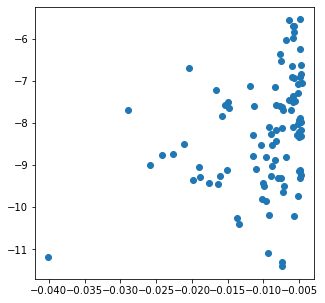




Generation: 3

N pep:  438
Best peptide: -11.406
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 005
N pep under -10 kcal/mol: 022
N pep under -9 kcal/mol: 076
N pep under -8 kcal/mol: 149
N pep under -7 kcal/mol: 244
N pep under -6 kcal/mol: 352
N pep under -5 kcal/mol: 432
Non binding pep        : 006


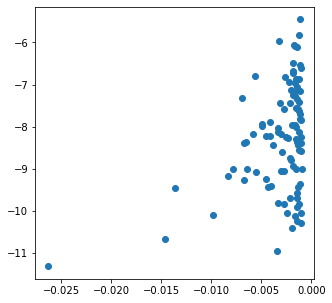




Run: 4
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.186
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 008
N pep under -7 kcal/mol: 029
N pep under -6 kcal/mol: 088
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.742
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 003
N pep under -10 kcal/mol: 010
N pep under -9 kcal/mol: 027
N pep under -8 kcal/mol: 066
N pep under -7 kcal/mol: 100
N pep under -6 kcal/mol: 175
N pep under -5 kcal/mol: 243
Non binding pep        : 003


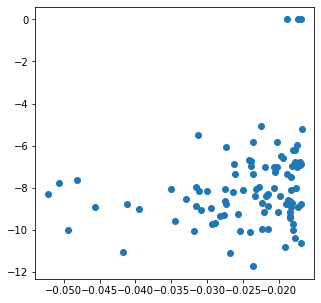




Generation: 2

N pep:  342
Best peptide: -11.742
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 004
N pep under -10 kcal/mol: 018
N pep under -9 kcal/mol: 057
N pep under -8 kcal/mol: 122
N pep under -7 kcal/mol: 175
N pep under -6 kcal/mol: 269
N pep under -5 kcal/mol: 339
Non binding pep        : 003


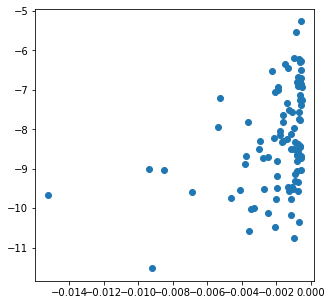




Generation: 3

N pep:  438
Best peptide: -11.935
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 005
N pep under -10 kcal/mol: 029
N pep under -9 kcal/mol: 096
N pep under -8 kcal/mol: 189
N pep under -7 kcal/mol: 264
N pep under -6 kcal/mol: 365
N pep under -5 kcal/mol: 435
Non binding pep        : 003


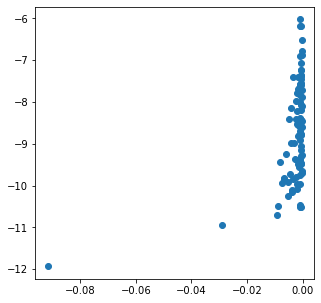




Run: 5
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.168
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 004
N pep under -7 kcal/mol: 040
N pep under -6 kcal/mol: 094
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.692
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 008
N pep under -9 kcal/mol: 022
N pep under -8 kcal/mol: 048
N pep under -7 kcal/mol: 111
N pep under -6 kcal/mol: 178
N pep under -5 kcal/mol: 243
Non binding pep        : 003


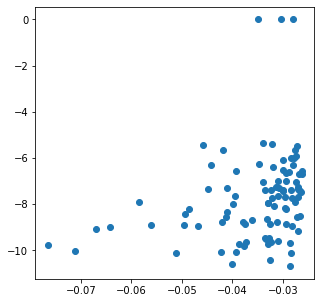




Generation: 2

N pep:  342
Best peptide: -10.717
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 015
N pep under -9 kcal/mol: 043
N pep under -8 kcal/mol: 096
N pep under -7 kcal/mol: 186
N pep under -6 kcal/mol: 271
N pep under -5 kcal/mol: 339
Non binding pep        : 003


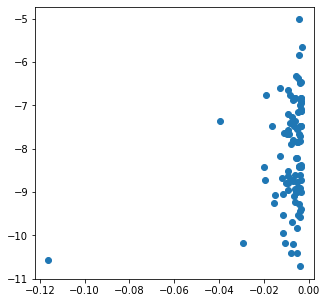




Generation: 3

N pep:  438
Best peptide: -11.400
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 003
N pep under -10 kcal/mol: 028
N pep under -9 kcal/mol: 083
N pep under -8 kcal/mol: 166
N pep under -7 kcal/mol: 275
N pep under -6 kcal/mol: 367
N pep under -5 kcal/mol: 435
Non binding pep        : 003


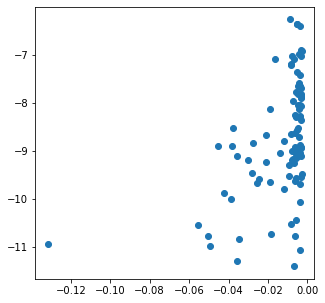




Run: 6
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.193
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 002
N pep under -7 kcal/mol: 032
N pep under -6 kcal/mol: 078
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.421
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 002
N pep under -9 kcal/mol: 011
N pep under -8 kcal/mol: 029
N pep under -7 kcal/mol: 081
N pep under -6 kcal/mol: 160
N pep under -5 kcal/mol: 241
Non binding pep        : 005


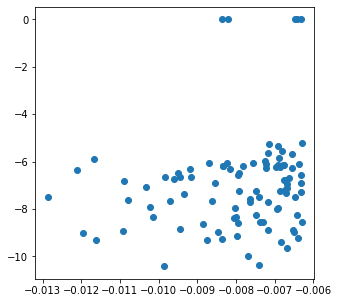




Generation: 2

N pep:  342
Best peptide: -11.216
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 004
N pep under -9 kcal/mol: 026
N pep under -8 kcal/mol: 076
N pep under -7 kcal/mol: 159
N pep under -6 kcal/mol: 252
N pep under -5 kcal/mol: 337
Non binding pep        : 005


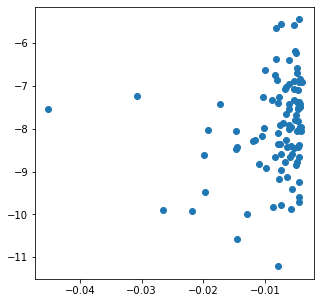




Generation: 3

N pep:  438
Best peptide: -11.216
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 003
N pep under -10 kcal/mol: 016
N pep under -9 kcal/mol: 061
N pep under -8 kcal/mol: 136
N pep under -7 kcal/mol: 248
N pep under -6 kcal/mol: 345
N pep under -5 kcal/mol: 433
Non binding pep        : 005


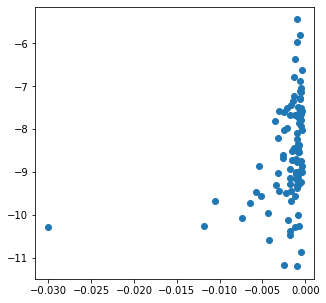




Run: 7
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.181
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 036
N pep under -6 kcal/mol: 088
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.741
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 008
N pep under -9 kcal/mol: 022
N pep under -8 kcal/mol: 034
N pep under -7 kcal/mol: 092
N pep under -6 kcal/mol: 168
N pep under -5 kcal/mol: 244
Non binding pep        : 002


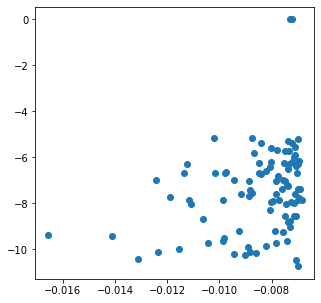




Generation: 2

N pep:  342
Best peptide: -11.174
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 003
N pep under -10 kcal/mol: 016
N pep under -9 kcal/mol: 050
N pep under -8 kcal/mol: 089
N pep under -7 kcal/mol: 173
N pep under -6 kcal/mol: 258
N pep under -5 kcal/mol: 340
Non binding pep        : 002


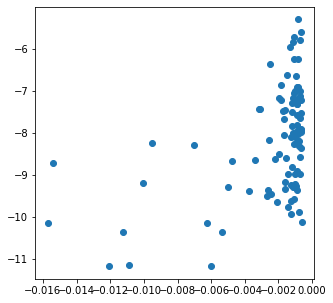




Generation: 3

N pep:  438
Best peptide: -11.556
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 004
N pep under -10 kcal/mol: 028
N pep under -9 kcal/mol: 084
N pep under -8 kcal/mol: 163
N pep under -7 kcal/mol: 263
N pep under -6 kcal/mol: 353
N pep under -5 kcal/mol: 436
Non binding pep        : 002


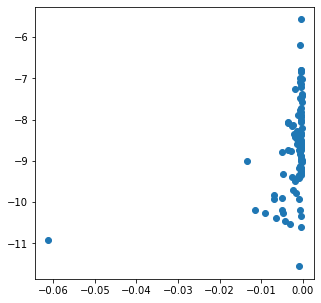




Run: 8
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.172
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 009
N pep under -7 kcal/mol: 050
N pep under -6 kcal/mol: 099
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.141
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 019
N pep under -8 kcal/mol: 053
N pep under -7 kcal/mol: 119
N pep under -6 kcal/mol: 189
N pep under -5 kcal/mol: 243
Non binding pep        : 003


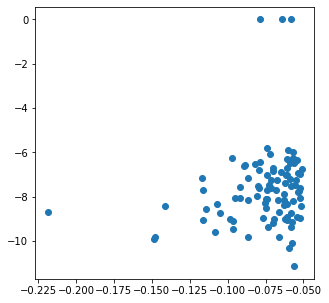




Generation: 2

N pep:  342
Best peptide: -11.141
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 009
N pep under -9 kcal/mol: 042
N pep under -8 kcal/mol: 104
N pep under -7 kcal/mol: 201
N pep under -6 kcal/mol: 280
N pep under -5 kcal/mol: 338
Non binding pep        : 004


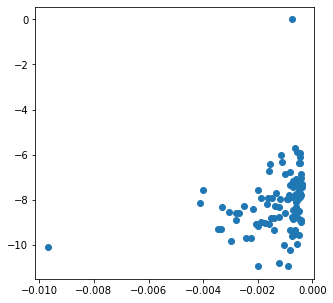




Generation: 3

N pep:  438
Best peptide: -11.793
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 004
N pep under -10 kcal/mol: 019
N pep under -9 kcal/mol: 076
N pep under -8 kcal/mol: 170
N pep under -7 kcal/mol: 288
N pep under -6 kcal/mol: 375
N pep under -5 kcal/mol: 434
Non binding pep        : 004


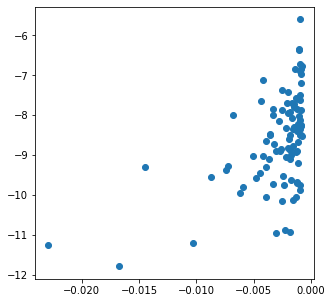




Run: 9
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.193
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 008
N pep under -7 kcal/mol: 039
N pep under -6 kcal/mol: 091
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.286
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 004
N pep under -10 kcal/mol: 008
N pep under -9 kcal/mol: 017
N pep under -8 kcal/mol: 041
N pep under -7 kcal/mol: 101
N pep under -6 kcal/mol: 176
N pep under -5 kcal/mol: 245
Non binding pep        : 001


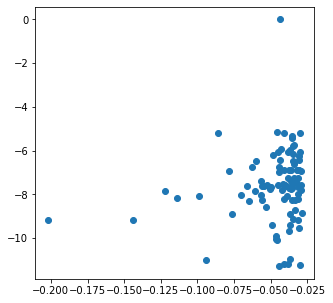




Generation: 2

N pep:  342
Best peptide: -11.708
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 007
N pep under -10 kcal/mol: 020
N pep under -9 kcal/mol: 060
N pep under -8 kcal/mol: 109
N pep under -7 kcal/mol: 184
N pep under -6 kcal/mol: 270
N pep under -5 kcal/mol: 341
Non binding pep        : 001


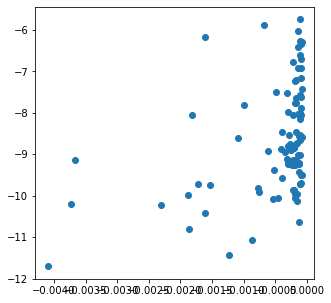




Generation: 3

N pep:  438
Best peptide: -11.708
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 008
N pep under -10 kcal/mol: 027
N pep under -9 kcal/mol: 100
N pep under -8 kcal/mol: 183
N pep under -7 kcal/mol: 275
N pep under -6 kcal/mol: 364
N pep under -5 kcal/mol: 437
Non binding pep        : 001


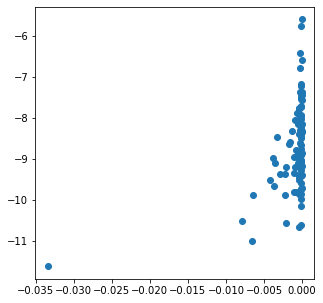




Run: 10
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.139
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 002
N pep under -7 kcal/mol: 029
N pep under -6 kcal/mol: 081
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.156
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 007
N pep under -9 kcal/mol: 020
N pep under -8 kcal/mol: 049
N pep under -7 kcal/mol: 096
N pep under -6 kcal/mol: 168
N pep under -5 kcal/mol: 244
Non binding pep        : 002


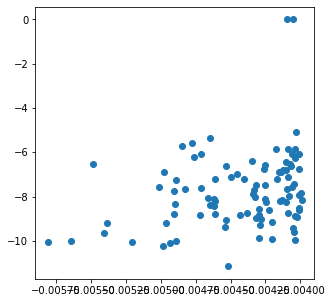




Generation: 2

N pep:  342
Best peptide: -11.156
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 015
N pep under -9 kcal/mol: 045
N pep under -8 kcal/mol: 104
N pep under -7 kcal/mol: 177
N pep under -6 kcal/mol: 262
N pep under -5 kcal/mol: 340
Non binding pep        : 002


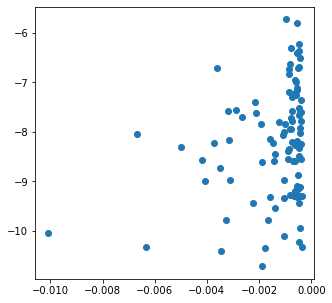




Generation: 3

N pep:  438
Best peptide: -11.883
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 003
N pep under -10 kcal/mol: 019
N pep under -9 kcal/mol: 068
N pep under -8 kcal/mol: 165
N pep under -7 kcal/mol: 262
N pep under -6 kcal/mol: 356
N pep under -5 kcal/mol: 436
Non binding pep        : 002


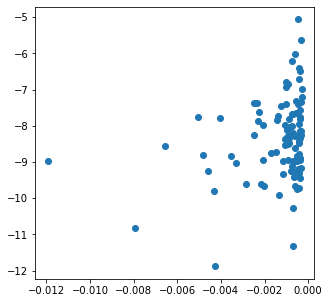

In [61]:
random_candidate_fps = []
random_candidate_y = []

n_peptides = 150
peptide_length = 9
energy_bounds = [-8.2, -5] # about between 1 and 250 uM
energy_cutoff = -5 # around 250 uM

for i in range(10):
    print('Run: %s' % (i + 1))
    
    # Generate random peptides
    random_peptides, random_peptide_scores = generate_random_peptides(n_peptides, peptide_length, pssm, reg,
                                                                      energy_bounds, energy_cutoff)
    
    # Compute the MAP4 fingerprint for all the peptides
    X_fps_exp = map4_fingerprint(random_peptides)
    y_exp = torch.from_numpy(random_peptide_scores).float()
    print('Exp dataset size: (%d, %d)' % (X_fps_exp.shape[0], X_fps_exp.shape[1]))
    
    print('\n\n')
    
    print('Init.')
    print('N pep: ', X_fps_exp.shape[0])
    print('Best peptide: %.3f' % y_exp.min())
    for n in [-12, -11, -10, -9, -8, -7, -6, -5]:
        print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
    print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))

    print('\n\n')

    for j in range(3):
        print('Generation: %d' % (j + 1))
        # Train GP model
        model = get_fitted_model(X_fps_exp, y_exp, kernel=TanimotoSimilarityKernel)

        # Find new candidates
        #acq = AcqScoring(model, probability_of_improvement, y_exp)
        acq = AcqScoring(model, expected_improvement, y_exp)
        candidate_sequences, candidates_acq = find_next_candidates_by_random(acq, greater_is_better=False)

        # Add candidates to the training set
        candidate_fps = map4_fingerprint(candidate_sequences)
        y_candidates = torch.from_numpy(np.array(predict_peptide_affinity_binding(candidate_sequences, pssm, reg)))

        X_fps_exp = torch.cat([X_fps_exp, candidate_fps])
        y_exp = torch.cat([y_exp, y_candidates])

        print('')
        print('N pep: ', X_fps_exp.shape[0])
        print('Best peptide: %.3f' % y_exp.min())
        for n in [-12, -11, -10, -9, -8,  -7, -6, -5]:
            print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
        print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.scatter(candidates_acq, y_candidates.numpy())
        plt.show()

        print('\n\n')
    
    
    random_candidate_fps.append(X_fps_exp.detach().numpy())
    random_candidate_y.append(y_exp.detach().numpy())


random_candidate_fps = np.array(random_candidate_fps)
random_candidate_y = np.array(random_candidate_y)

### Candidate peptides sampling with custom GA

In [23]:
def parse_helm(helm_string):
    dtype = [('SourcePolymerID', 'U20'), ('TargetPolymerID', 'U20'),
             ('SourceMonomerPosition', 'i4'), ('SourceAttachment', 'U2'),
             ('TargetMonomerPosition', 'i4'), ('TargetAttachment', 'U2')]
    
    polymers, connections, hydrogen_bonds, attributes, _ = helm_string.split('$')
    
    # Process sequences
    data = {}
    for polymer in polymers.split('|'):
        pid = polymer.split('{')[0]
        sequence = polymer[len(pid) + 1:-1].replace('.', '')
        data[pid] = sequence
        
    polymers = data
        
    # Process connections
    data = []
    if connections:
        for connection in connections.split('|'):
            source_id, target_id, con = connection.split(',')
            source_position, source_attachment = con.split('-')[0].split(':')
            target_position, target_attachment = con.split('-')[1].split(':')
            data.append((source_id, target_id,
                         source_position, source_attachment,
                         target_position, target_attachment))
        
    connections = np.array(data, dtype=dtype)
    
    return polymers, connections, hydrogen_bonds, attributes


def build_helm_string(polymers, connections):
    sequences_str = '|'.join(['%s{%s}' % (p, '.'.join(s)) for p, s in polymers.items()])
    if len(connections) > 0:
        connections_str = '|'.join(['%s,%s,%d:%s-%d:%s' % (c[0], c[1], c[2], c[3], c[4], c[5]) for c in connections])
    else:
        connections_str = ''
    helm_string = '%s$%s$$$V2.0' % (sequences_str, connections_str)
    
    return helm_string


class HELMGeneticOperators:
    
    def __init__(self, monomer_library, probability_matrix=None, seed=None):
        self._monomer_library = monomer_library
        self._monomer_symbols = [m['symbol'] for m in self._monomer_library]
        self._probability_matrix = probability_matrix
        
        self._random_seed = seed
        self._rng = np.random.default_rng(self._random_seed)

    def mutate(self, helm_string, n=10, minimum_mutations=1, maximum_mutations=None, keep_connections=True):
        mutant_helm_strings = []
        
        polymers, connections, _, _ = parse_helm(helm_string)
        
        # Generate mutants...
        for i in range(n):
            mutant_polymers = {}
            n_mutations = 0
            
            for pid, sequence in polymers.items():
                mutated_sequence = list(sequence)
                
                # Residues involved in a connection within and between peptides won't be mutated
                if keep_connections and pid in polymers.keys():
                    connection_resids = list(connections[connections['SourcePolymerID'] == pid]['SourceMonomerPosition'])
                    connection_resids += list(connections[connections['TargetPolymerID'] == pid]['TargetMonomerPosition'])
                    # Because positions are 1-based in HELM
                    connection_resids = np.array(connection_resids) - 1
                    
                    possible_positions = list(set(range(len(sequence))).difference(connection_resids))
                else:
                    possible_positions = list(range(len(sequence)))
                
                # Choose a random number of mutations between min and max
                if minimum_mutations == maximum_mutations:
                    number_mutations = maximum_mutations
                elif maximum_mutations is None:
                    number_mutations = self._rng.integers(low=minimum_mutations, high=len(sequence))
                else:
                    number_mutations = self._rng.integers(low=minimum_mutations, high=maximum_mutations)
                
                # Choose positions to mutate
                mutation_positions = self._rng.choice(possible_positions, size=number_mutations, replace=False)
                
                # Do mutations
                for mutation_position in mutation_positions:                    
                    monomer_symbol = mutated_sequence[mutation_position]
                    
                    # Force mutation!
                    while monomer_symbol == mutated_sequence[mutation_position]:
                        # Instead of mutating to random monomer, the selection will be
                        # based on the probability matrix
                        if self._probability_matrix is not None:
                            index_symbol = self._monomer_symbols.index(monomer_symbol)
                            p = probability_matrix[index_symbol]
                        else:
                            p = None
                        
                        chosen_monomer = self._rng.choice(self._monomer_symbols, p=p)
                        mutated_sequence[mutation_position] = chosen_monomer
                
                mutant_polymers[pid] = (mutated_sequence, mutation_positions)
                n_mutations += len(mutation_positions)
            
            if n_mutations > 0:
                if not keep_connections:
                    connections_to_keep = []

                    # Check if we have to remove connections due to the mutations
                    for i, connection in enumerate(connections):
                        # The connection positions must not be in the mutation lists
                        # mutant_polymers[connection['XXXXXPolymerID']][1] + 1 because positions are 1-based in HELM
                        if connection['SourceMonomerPosition'] not in mutant_polymers[connection['SourcePolymerID']][1] + 1 and \
                           connection['TargetMonomerPosition'] not in mutant_polymers[connection['TargetPolymerID']][1] + 1:
                            connections_to_keep.append(i)
                else:
                    connections_to_keep = list(range(connections.shape[0]))

                # Reconstruct the HELM string
                mutant_helm_string = build_helm_string({p: s[0] for p, s in mutant_polymers.items()}, connections[connections_to_keep])
                mutant_helm_strings.append(mutant_helm_string)
            else:
                mutant_helm_strings.append(helm_string)
        
        return mutant_helm_strings
            

In [70]:
def find_next_candidates_with_custom_GA(scorer, best_peptide, monomer_lib, probability_matrix, greater_is_better=True):
    NGEN = 10
    NIND = 250
    NBEST = 50
    NLEN = 9
    NCAN = 96
    
    polymers = {'PEPTIDE1': best_peptide}
    helm_string = build_helm_string(polymers, [])
    m = HELMGeneticOperators(monomer_lib, probability_matrix=probability_matrix)
    
    all_sequences = []
    all_sequence_acqs = []
    
    for i in range(NGEN):
        sequences = m.mutate(helm_string, n=NIND, minimum_mutations=1, maximum_mutations=2)
        sequence_acqs = scorer.evaluate(sequences)
        
        # Take the best peptide
        if greater_is_better:
            seq_idx = np.argmax(np.ravel(sequence_acqs))
        else:
            seq_idx = np.argmin(np.ravel(sequence_acqs))
            
        helm_string = sequences[seq_idx]
        
        all_sequences.extend(sequences)
        all_sequence_acqs.extend(np.ravel(sequence_acqs))
        
    # Remove duplicates
    all_sequences, indices = np.unique(all_sequences, return_index=True)
    all_sequence_acqs = np.array(all_sequence_acqs)[indices]
        
    if greater_is_better:
        sorted_peptide_indices = np.argsort(all_sequence_acqs)[::-1]
    else:
        sorted_peptide_indices = np.argsort(all_sequence_acqs)
    
    # Select candidates
    candidates = all_sequences[sorted_peptide_indices[:NCAN]]
    candidate_acqs = all_sequence_acqs[sorted_peptide_indices[:NCAN]]
    
    # Convert HELM to FASTA
    candidates = [''.join(c.split('$')[0].split('{')[1].split('}')[0].split('.')) for c in candidates]
                        
    return candidates, candidate_acqs

In [66]:
with open('HELMCoreLibrary.json') as f:
    monomer_lib = json.load(f)

monomer_peptide_lib = [x for x in monomer_lib if x['polymerType'] == 'PEPTIDE']
AA1 = ["A", "R", "N", "D", "C", "E", "Q", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]
monomer_aa1_lib = [x for x in monomer_peptide_lib if x['symbol'] in AA1]

smiles = [monomer['smiles'] for monomer in monomer_aa1_lib]
fps = map4_fingerprint(smiles,input_type='smiles', radius=2)
t = TanimotoSimilarityKernel()
similarity_matrix = t.forward(fps, fps).numpy()

probability_matrix = []

for aa in similarity_matrix:
    tmp = aa.copy()
    tmp[tmp == 1.0] = 0
    probability_matrix.append(tmp / np.sum(tmp))
    
probability_matrix = np.array(probability_matrix)

Run: 1
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.172
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 040
N pep under -6 kcal/mol: 084
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -12.164
N pep under -12 kcal/mol: 004
N pep under -11 kcal/mol: 044
N pep under -10 kcal/mol: 078
N pep under -9 kcal/mol: 090
N pep under -8 kcal/mol: 099
N pep under -7 kcal/mol: 136
N pep under -6 kcal/mol: 180
N pep under -5 kcal/mol: 246
Non binding pep        : 000


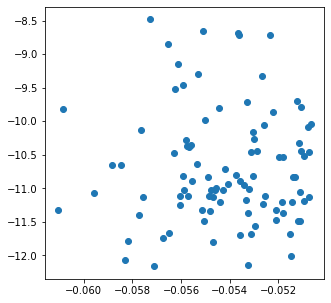




Generation: 2

N pep:  342
Best peptide: -13.035
N pep under -12 kcal/mol: 076
N pep under -11 kcal/mol: 140
N pep under -10 kcal/mol: 174
N pep under -9 kcal/mol: 186
N pep under -8 kcal/mol: 195
N pep under -7 kcal/mol: 232
N pep under -6 kcal/mol: 276
N pep under -5 kcal/mol: 342
Non binding pep        : 000


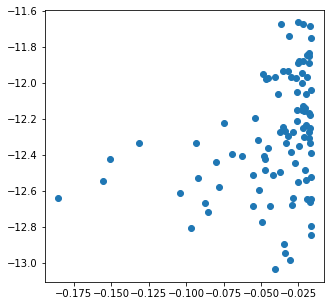




Generation: 3

N pep:  438
Best peptide: -13.710
N pep under -12 kcal/mol: 172
N pep under -11 kcal/mol: 236
N pep under -10 kcal/mol: 270
N pep under -9 kcal/mol: 282
N pep under -8 kcal/mol: 291
N pep under -7 kcal/mol: 328
N pep under -6 kcal/mol: 372
N pep under -5 kcal/mol: 438
Non binding pep        : 000


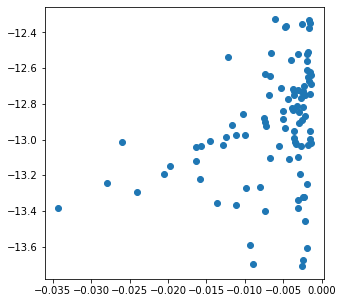




Run: 2
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.158
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 032
N pep under -6 kcal/mol: 089
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.921
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 061
N pep under -10 kcal/mol: 087
N pep under -9 kcal/mol: 096
N pep under -8 kcal/mol: 099
N pep under -7 kcal/mol: 128
N pep under -6 kcal/mol: 185
N pep under -5 kcal/mol: 246
Non binding pep        : 000


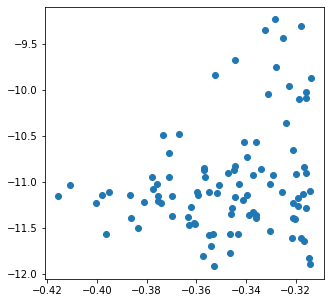




Generation: 2

N pep:  342
Best peptide: -12.865
N pep under -12 kcal/mol: 065
N pep under -11 kcal/mol: 156
N pep under -10 kcal/mol: 183
N pep under -9 kcal/mol: 192
N pep under -8 kcal/mol: 195
N pep under -7 kcal/mol: 224
N pep under -6 kcal/mol: 281
N pep under -5 kcal/mol: 342
Non binding pep        : 000


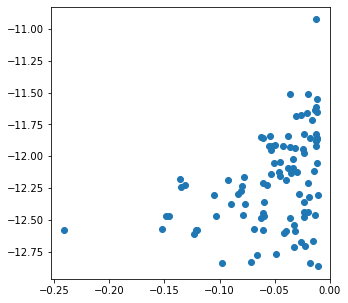




Generation: 3

N pep:  438
Best peptide: -13.249
N pep under -12 kcal/mol: 159
N pep under -11 kcal/mol: 252
N pep under -10 kcal/mol: 279
N pep under -9 kcal/mol: 288
N pep under -8 kcal/mol: 291
N pep under -7 kcal/mol: 320
N pep under -6 kcal/mol: 377
N pep under -5 kcal/mol: 438
Non binding pep        : 000


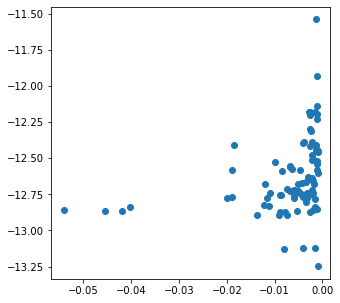




Run: 3
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.190
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 006
N pep under -7 kcal/mol: 039
N pep under -6 kcal/mol: 087
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -12.700
N pep under -12 kcal/mol: 006
N pep under -11 kcal/mol: 018
N pep under -10 kcal/mol: 060
N pep under -9 kcal/mol: 094
N pep under -8 kcal/mol: 101
N pep under -7 kcal/mol: 135
N pep under -6 kcal/mol: 183
N pep under -5 kcal/mol: 246
Non binding pep        : 000


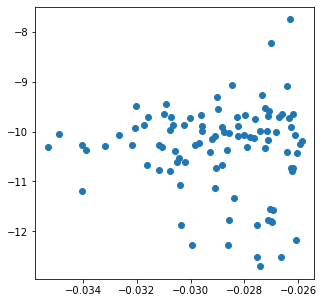




Generation: 2

N pep:  342
Best peptide: -13.751
N pep under -12 kcal/mol: 102
N pep under -11 kcal/mol: 114
N pep under -10 kcal/mol: 156
N pep under -9 kcal/mol: 190
N pep under -8 kcal/mol: 197
N pep under -7 kcal/mol: 231
N pep under -6 kcal/mol: 279
N pep under -5 kcal/mol: 342
Non binding pep        : 000


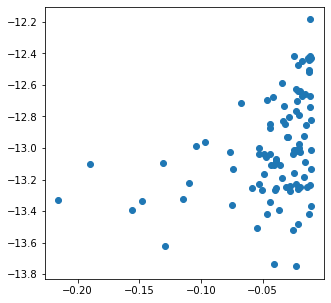




Generation: 3

N pep:  438
Best peptide: -14.248
N pep under -12 kcal/mol: 198
N pep under -11 kcal/mol: 210
N pep under -10 kcal/mol: 252
N pep under -9 kcal/mol: 286
N pep under -8 kcal/mol: 293
N pep under -7 kcal/mol: 327
N pep under -6 kcal/mol: 375
N pep under -5 kcal/mol: 438
Non binding pep        : 000


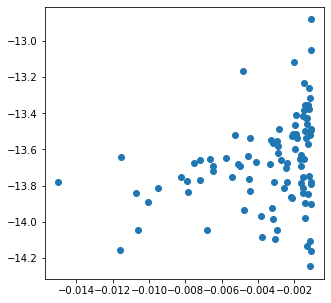




Run: 4
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.122
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 031
N pep under -6 kcal/mol: 076
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.700
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 013
N pep under -9 kcal/mol: 089
N pep under -8 kcal/mol: 099
N pep under -7 kcal/mol: 127
N pep under -6 kcal/mol: 172
N pep under -5 kcal/mol: 246
Non binding pep        : 000


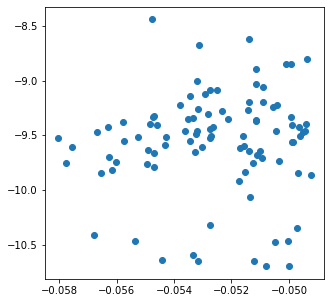




Generation: 2

N pep:  342
Best peptide: -12.473
N pep under -12 kcal/mol: 010
N pep under -11 kcal/mol: 093
N pep under -10 kcal/mol: 109
N pep under -9 kcal/mol: 185
N pep under -8 kcal/mol: 195
N pep under -7 kcal/mol: 223
N pep under -6 kcal/mol: 268
N pep under -5 kcal/mol: 342
Non binding pep        : 000


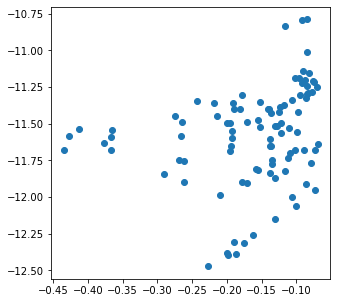




Generation: 3

N pep:  438
Best peptide: -13.360
N pep under -12 kcal/mol: 106
N pep under -11 kcal/mol: 189
N pep under -10 kcal/mol: 205
N pep under -9 kcal/mol: 281
N pep under -8 kcal/mol: 291
N pep under -7 kcal/mol: 319
N pep under -6 kcal/mol: 364
N pep under -5 kcal/mol: 438
Non binding pep        : 000


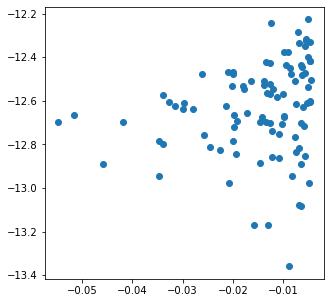




Run: 5
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.197
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 005
N pep under -7 kcal/mol: 037
N pep under -6 kcal/mol: 097
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.841
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 023
N pep under -10 kcal/mol: 073
N pep under -9 kcal/mol: 081
N pep under -8 kcal/mol: 101
N pep under -7 kcal/mol: 133
N pep under -6 kcal/mol: 193
N pep under -5 kcal/mol: 246
Non binding pep        : 000


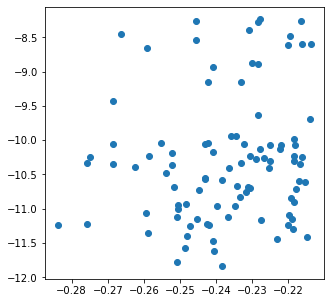




Generation: 2

N pep:  342
Best peptide: -12.838
N pep under -12 kcal/mol: 053
N pep under -11 kcal/mol: 119
N pep under -10 kcal/mol: 169
N pep under -9 kcal/mol: 177
N pep under -8 kcal/mol: 197
N pep under -7 kcal/mol: 229
N pep under -6 kcal/mol: 289
N pep under -5 kcal/mol: 342
Non binding pep        : 000


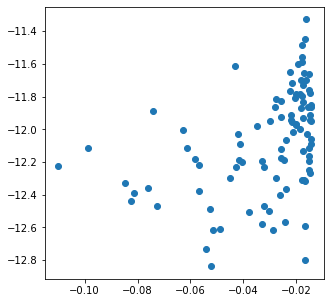




Generation: 3

N pep:  438
Best peptide: -13.752
N pep under -12 kcal/mol: 149
N pep under -11 kcal/mol: 215
N pep under -10 kcal/mol: 265
N pep under -9 kcal/mol: 273
N pep under -8 kcal/mol: 293
N pep under -7 kcal/mol: 325
N pep under -6 kcal/mol: 385
N pep under -5 kcal/mol: 438
Non binding pep        : 000


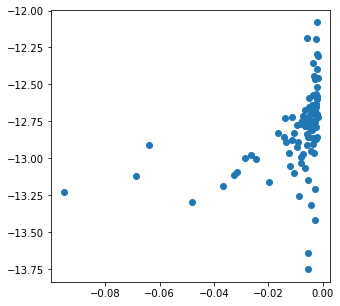




Run: 6
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.193
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 006
N pep under -7 kcal/mol: 032
N pep under -6 kcal/mol: 086
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.333
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 004
N pep under -10 kcal/mol: 066
N pep under -9 kcal/mol: 089
N pep under -8 kcal/mol: 099
N pep under -7 kcal/mol: 128
N pep under -6 kcal/mol: 182
N pep under -5 kcal/mol: 246
Non binding pep        : 000


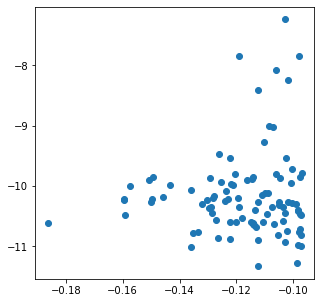




Generation: 2

N pep:  342
Best peptide: -12.654
N pep under -12 kcal/mol: 011
N pep under -11 kcal/mol: 097
N pep under -10 kcal/mol: 162
N pep under -9 kcal/mol: 185
N pep under -8 kcal/mol: 195
N pep under -7 kcal/mol: 224
N pep under -6 kcal/mol: 278
N pep under -5 kcal/mol: 342
Non binding pep        : 000


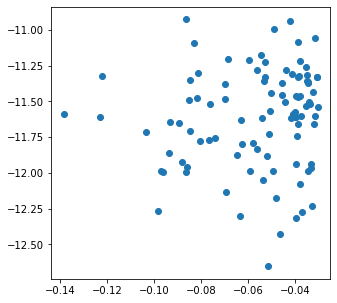




Generation: 3

N pep:  438
Best peptide: -13.627
N pep under -12 kcal/mol: 107
N pep under -11 kcal/mol: 193
N pep under -10 kcal/mol: 258
N pep under -9 kcal/mol: 281
N pep under -8 kcal/mol: 291
N pep under -7 kcal/mol: 320
N pep under -6 kcal/mol: 374
N pep under -5 kcal/mol: 438
Non binding pep        : 000


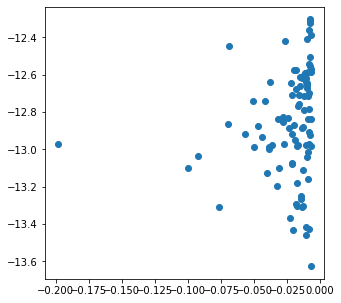




Run: 7
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.099
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 027
N pep under -6 kcal/mol: 085
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.322
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 005
N pep under -9 kcal/mol: 035
N pep under -8 kcal/mol: 087
N pep under -7 kcal/mol: 123
N pep under -6 kcal/mol: 181
N pep under -5 kcal/mol: 246
Non binding pep        : 000


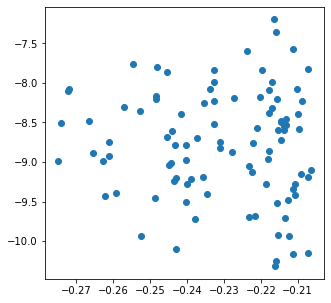




Generation: 2

N pep:  342
Best peptide: -12.773
N pep under -12 kcal/mol: 013
N pep under -11 kcal/mol: 085
N pep under -10 kcal/mol: 101
N pep under -9 kcal/mol: 131
N pep under -8 kcal/mol: 183
N pep under -7 kcal/mol: 219
N pep under -6 kcal/mol: 277
N pep under -5 kcal/mol: 342
Non binding pep        : 000


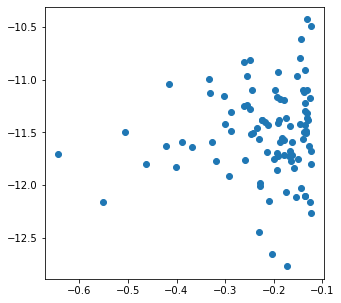




Generation: 3

N pep:  438
Best peptide: -13.780
N pep under -12 kcal/mol: 109
N pep under -11 kcal/mol: 181
N pep under -10 kcal/mol: 197
N pep under -9 kcal/mol: 227
N pep under -8 kcal/mol: 279
N pep under -7 kcal/mol: 315
N pep under -6 kcal/mol: 373
N pep under -5 kcal/mol: 438
Non binding pep        : 000


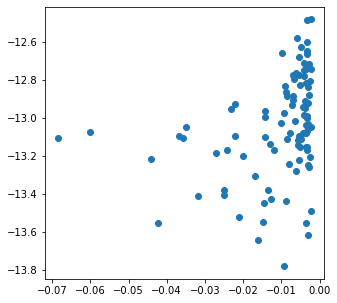




Run: 8
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.176
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 005
N pep under -7 kcal/mol: 038
N pep under -6 kcal/mol: 087
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -12.222
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 005
N pep under -10 kcal/mol: 041
N pep under -9 kcal/mol: 092
N pep under -8 kcal/mol: 100
N pep under -7 kcal/mol: 134
N pep under -6 kcal/mol: 183
N pep under -5 kcal/mol: 246
Non binding pep        : 000


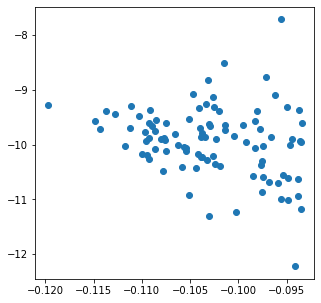




Generation: 2

N pep:  342
Best peptide: -12.929
N pep under -12 kcal/mol: 081
N pep under -11 kcal/mol: 101
N pep under -10 kcal/mol: 137
N pep under -9 kcal/mol: 188
N pep under -8 kcal/mol: 196
N pep under -7 kcal/mol: 230
N pep under -6 kcal/mol: 279
N pep under -5 kcal/mol: 342
Non binding pep        : 000


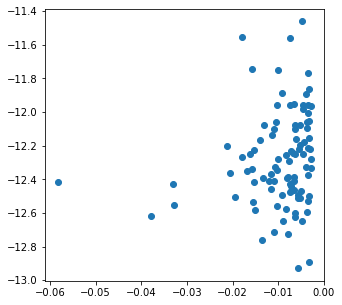




Generation: 3

N pep:  438
Best peptide: -13.408
N pep under -12 kcal/mol: 172
N pep under -11 kcal/mol: 194
N pep under -10 kcal/mol: 233
N pep under -9 kcal/mol: 284
N pep under -8 kcal/mol: 292
N pep under -7 kcal/mol: 326
N pep under -6 kcal/mol: 375
N pep under -5 kcal/mol: 438
Non binding pep        : 000


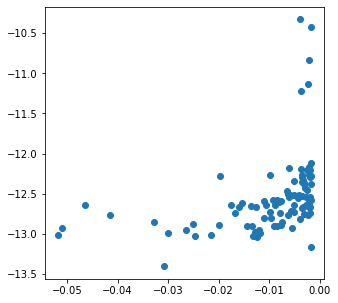




Run: 9
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.188
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 004
N pep under -7 kcal/mol: 039
N pep under -6 kcal/mol: 089
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.954
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 006
N pep under -10 kcal/mol: 043
N pep under -9 kcal/mol: 070
N pep under -8 kcal/mol: 092
N pep under -7 kcal/mol: 133
N pep under -6 kcal/mol: 184
N pep under -5 kcal/mol: 246
Non binding pep        : 000


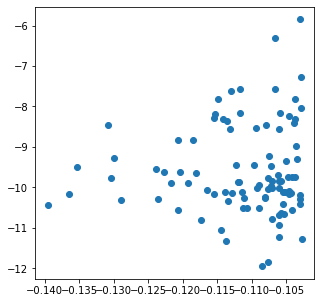




Generation: 2

N pep:  342
Best peptide: -13.227
N pep under -12 kcal/mol: 048
N pep under -11 kcal/mol: 100
N pep under -10 kcal/mol: 139
N pep under -9 kcal/mol: 166
N pep under -8 kcal/mol: 188
N pep under -7 kcal/mol: 229
N pep under -6 kcal/mol: 280
N pep under -5 kcal/mol: 342
Non binding pep        : 000


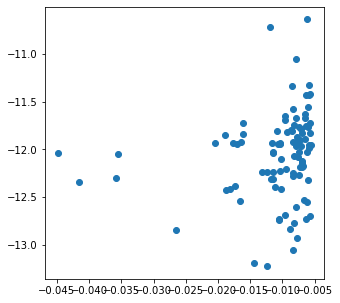




Generation: 3

N pep:  438
Best peptide: -14.109
N pep under -12 kcal/mol: 144
N pep under -11 kcal/mol: 196
N pep under -10 kcal/mol: 235
N pep under -9 kcal/mol: 262
N pep under -8 kcal/mol: 284
N pep under -7 kcal/mol: 325
N pep under -6 kcal/mol: 376
N pep under -5 kcal/mol: 438
Non binding pep        : 000


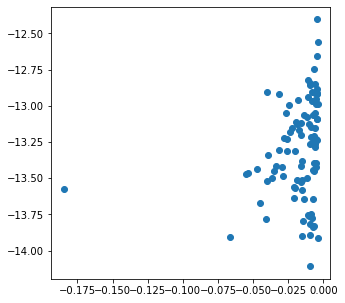




Run: 10
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.159
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 007
N pep under -7 kcal/mol: 038
N pep under -6 kcal/mol: 084
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.369
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 004
N pep under -9 kcal/mol: 079
N pep under -8 kcal/mol: 103
N pep under -7 kcal/mol: 134
N pep under -6 kcal/mol: 180
N pep under -5 kcal/mol: 246
Non binding pep        : 000


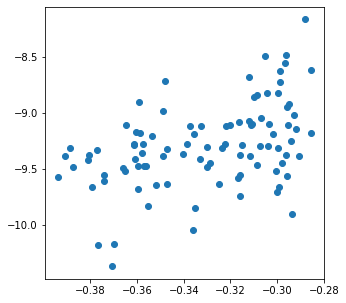




Generation: 2

N pep:  342
Best peptide: -12.926
N pep under -12 kcal/mol: 008
N pep under -11 kcal/mol: 036
N pep under -10 kcal/mol: 099
N pep under -9 kcal/mol: 175
N pep under -8 kcal/mol: 199
N pep under -7 kcal/mol: 230
N pep under -6 kcal/mol: 276
N pep under -5 kcal/mol: 342
Non binding pep        : 000


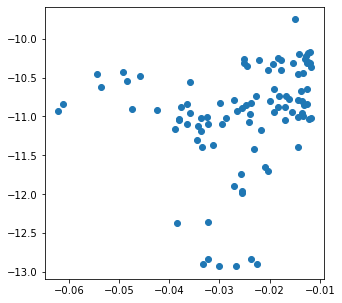




Generation: 3

N pep:  438
Best peptide: -13.392
N pep under -12 kcal/mol: 104
N pep under -11 kcal/mol: 132
N pep under -10 kcal/mol: 195
N pep under -9 kcal/mol: 271
N pep under -8 kcal/mol: 295
N pep under -7 kcal/mol: 326
N pep under -6 kcal/mol: 372
N pep under -5 kcal/mol: 438
Non binding pep        : 000


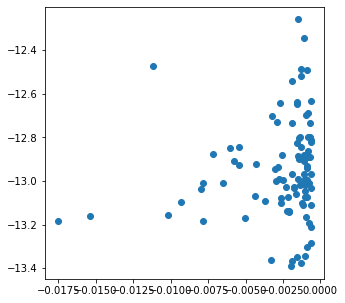

In [71]:
custom_candidate_fps = []
custom_candidate_y = []

n_peptides = 150
peptide_length = 9
energy_bounds = [-8.2, -5] # about between 1 and 250 uM
energy_cutoff = -5 # around 250 uM

for i in range(10):
    print('Run: %s' % (i + 1))
    
    # Generate random peptides
    random_peptides, random_peptide_scores = generate_random_peptides(n_peptides, peptide_length, pssm, reg,
                                                                      energy_bounds, energy_cutoff)
    # Get best random peptide
    best_peptide = random_peptides[np.argmin(random_peptide_scores)]
    
    # Compute the MAP4 fingerprint for all the peptides
    X_fps_exp = map4_fingerprint(random_peptides)
    y_exp = torch.from_numpy(random_peptide_scores).float()
    print('Exp dataset size: (%d, %d)' % (X_fps_exp.shape[0], X_fps_exp.shape[1]))
    
    print('\n\n')
    
    print('Init.')
    print('N pep: ', X_fps_exp.shape[0])
    print('Best peptide: %.3f' % y_exp.min())
    for n in [-12, -11, -10, -9, -8, -7, -6, -5]:
        print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
    print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))

    print('\n\n')

    for j in range(3):
        print('Generation: %d' % (j + 1))
        # Train GP model
        model = get_fitted_model(X_fps_exp, y_exp, kernel=TanimotoSimilarityKernel)

        # Find new candidates
        #acq = AcqScoring(model, probability_of_improvement, y_exp)
        acq = AcqScoring(model, expected_improvement, y_exp, sequence_type='helm')
        candidate_sequences, candidates_acq = find_next_candidates_with_custom_GA(acq, best_peptide, monomer_aa1_lib, probability_matrix, greater_is_better=False)

        # Add candidates to the training set
        candidate_fps = map4_fingerprint(candidate_sequences)
        y_candidates = torch.from_numpy(np.array(predict_peptide_affinity_binding(candidate_sequences, pssm, reg)))

        X_fps_exp = torch.cat([X_fps_exp, candidate_fps])
        y_exp = torch.cat([y_exp, y_candidates])
        
        # Get best peptide found so far
        best_peptide = candidate_sequences[np.argmin(y_candidates.numpy())]

        print('')
        print('N pep: ', X_fps_exp.shape[0])
        print('Best peptide: %.3f' % y_exp.min())
        for n in [-12, -11, -10, -9, -8,  -7, -6, -5]:
            print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
        print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.scatter(candidates_acq, y_candidates.numpy())
        plt.show()

        print('\n\n')
    
    
    custom_candidate_fps.append(X_fps_exp.detach().numpy())
    custom_candidate_y.append(y_exp.detach().numpy())


custom_candidate_fps = np.array(custom_candidate_fps)
custom_candidate_y = np.array(custom_candidate_y)

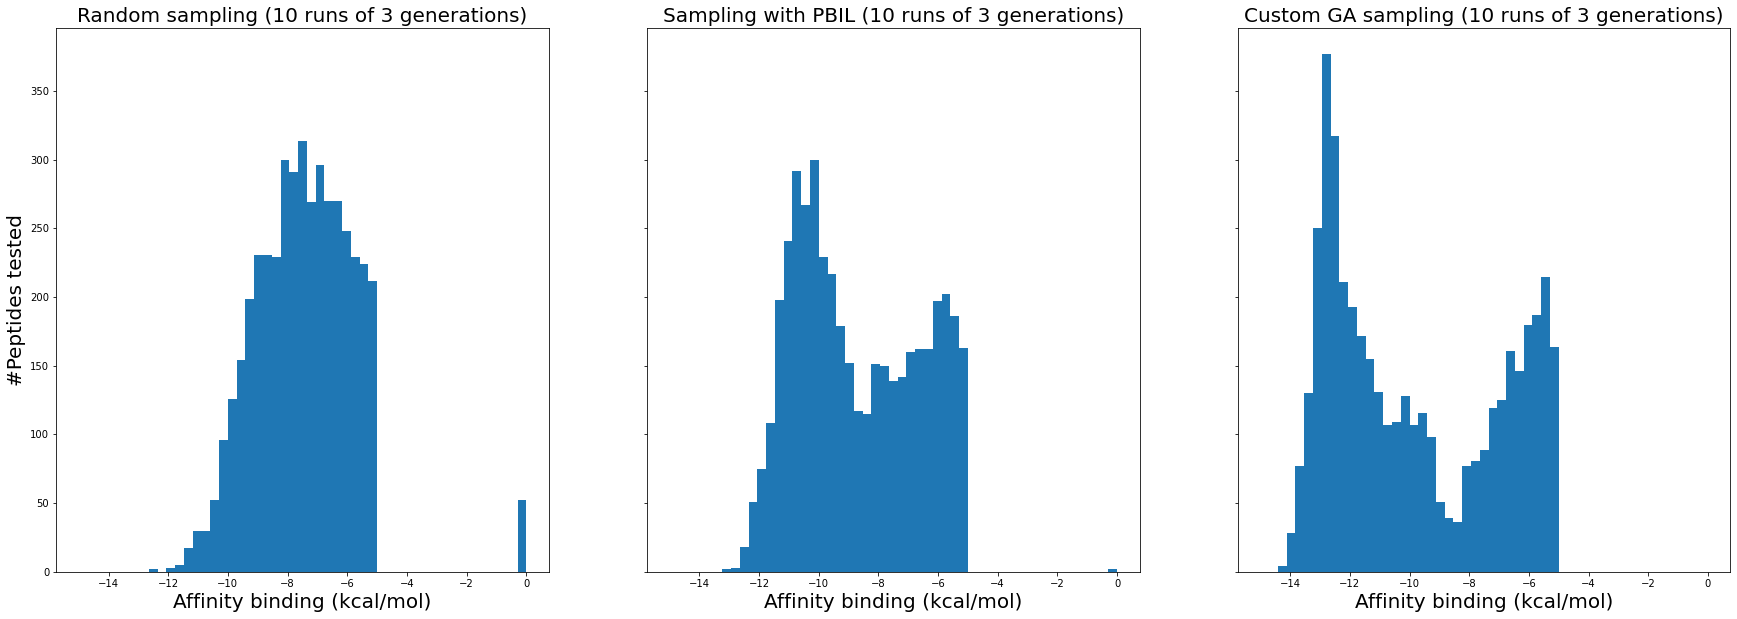

In [74]:
fig, axarr = plt.subplots(1, 3, figsize=(30, 10), sharey=True)
axarr[0].hist(random_candidate_y.flatten(), bins=np.linspace(-15, 0, 52))
axarr[1].hist(pbil_candidate_y.flatten(), bins=np.linspace(-15, 0, 52))
axarr[2].hist(custom_candidate_y.flatten(), bins=np.linspace(-15, 0, 52))

axarr[0].set_title('Random sampling (10 runs of 3 generations)', fontsize=20)
axarr[1].set_title('Sampling with PBIL (10 runs of 3 generations)', fontsize=20)
axarr[2].set_title('Custom GA sampling (10 runs of 3 generations)', fontsize=20)

axarr[0].set_ylabel('#Peptides tested', fontsize=20)
axarr[0].set_xlabel('Affinity binding (kcal/mol)', fontsize=20)
axarr[1].set_xlabel('Affinity binding (kcal/mol)', fontsize=20)
axarr[2].set_xlabel('Affinity binding (kcal/mol)', fontsize=20)

plt.savefig('figure_baye_opt_comparison_random_vs_pbil_vs_custom_GA_sampling.png', dpi=300, bbox_inches='tight')
plt.show()